In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from datetime import timedelta
% matplotlib inline
sns.set(style="darkgrid")
from bs4 import BeautifulSoup
import requests
import pprint
import re

In [2]:
%load_ext line_profiler

In [3]:
time1 = datetime.now()
df = pd.read_csv('../cleaned_flight_data_updated.csv')
# p = 1  # p% of lines
# filename = 'cleaned_flight_data.csv'
# random.seed(234)

# # if random from [0,1] > p, skip row
# df = pd.read_csv(
#          filename,
#          header=0, 
#          skiprows=lambda i: i>0 and random.random() > p/100
# )
time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (48,76,77,84,102,104,105,106,108,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:02:17.826684


# merge the passenger count of airports

In [17]:
df_1 = pd.read_csv('airport_delay.csv')

df_1 = df_1[['origin', 'passenger_count']]

df_1 = df_1.rename(columns={'origin': 'ORIGIN', 'passenger_count': 'origin_passenger_count'})

In [18]:
df['DEST'].head()

0    PSE
1    EWR
2    EWR
3    EWR
4    EWR
Name: DEST, dtype: object

In [19]:
df = df.merge(df_1, on='ORIGIN', how='left')

df_1 = pd.read_csv('airport_delay.csv')

df_1 = df_1[['origin', 'passenger_count']]

df_1 = df_1.rename(columns={'origin': 'DEST', 'passenger_count': 'dest_passenger_count'})
df = df.merge(df_1, on='DEST', how='left')

In [20]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0  2016        1      1             1            5  2016-01-01   
1  2016        1      1             1            5  2016-01-01   
2  2016        1      1             1            5  2016-01-01   
3  2016        1      1             1            5  2016-01-01   
4  2016        1      1             1            5  2016-01-01   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  \
0                B6                  20409         B6   N636JB   
1                B6                  20409         B6   N547JB   
2                WN                  19393         WN   N927WN   
3                UA                  19977         UA   N62849   
4                EV                  20366         EV   N10575   

           ...           HOURLYPRSENTWEATHERTYPE_dest  \
0          ...                                    NaN   
1          ...                                    NaN   
2          ...                                    NaN   
3          ...                                    NaN   
4          ...                                    NaN   

   HOURLYDRYBULBTEMPF_dest  HOURLYRelativeHumidity_dest  HOURLYWindSpeed_dest  \
0                       73                           83                     0   
1                       34                           50                    11   
2                       34                           50                    11   
3                       34                           50                    11   
4                       34                           50                    11   

  HOURLYWindDirection_dest HOURLYWindGustSpeed_dest HOURLYPrecip_dest  \
0                      000                      NaN               NaN   
1                      240                      NaN              0.00   
2                      240                      NaN              0.00   
3                      240                      NaN              0.00   
4                      240                      NaN              0.00   

   HOURLYAltimeterSetting_dest origin_passenger_count  dest_passenger_count  
0                        30.03             21565448.0               89334.0  
1                        30.05             21565448.0            21571198.0  
2                        30.05              7194745.0            21571198.0  
3                        30.05             19603731.0            21571198.0  
4                        30.05             18409704.0            21571198.0  

[5 rows x 123 columns]

In [21]:
df.to_csv('cleaned_flight_data_updated.csv', index=False)

# ______________________________

In [5]:
def find_closest_date(timepoint, time_series):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally
    # the number of days in its time delta
    timepoint = np.datetime64(timepoint)
    deltas = np.abs(np.subtract(time_series.values, timepoint))
    idx_closest_date = np.argmin(deltas)
    return time_series.index[idx_closest_date]

In [4]:
airport_lst = ['TKI']
tail_num_lst = ['PLANET', 'N101NK', 'N999FR', 'N700TA', 'N187SW', 'N399FR']
df = df[(~df['ORIGIN'].isin(airport_lst))
        & (~df['TAIL_NUM'].isin(tail_num_lst))]

# read wban_iata and weather data
wban_iata = pd.read_csv('../Weather Data/wban_to_iata.csv')
weather = pd.read_csv('../Weather Data/data/weather_pre.csv'
                      , parse_dates=['DATE'])
weather['WBAN'] = weather['STATION'].apply(lambda x: int(x[5:]))

# convert string into datetime
df['dep_time'] = df['CRS_DEP_TIME'].apply(
    lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00'
    if x >= 100 else '00:'+str(x)+':00')
df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
df['dep_datetime'] = pd.to_datetime(
    df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
df['arr_time'] = df['CRS_ARR_TIME'].apply(
    lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00'
    if x >= 100 else '00:'+str(x)+':00')
df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
df['arr_datetime'] = pd.to_datetime(
    df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

# add 1 day for flights overnight
df.arr_datetime = df[
    ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']
].apply(
    lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2],
    axis=1)

df = df.merge(
    wban_iata, left_on='ORIGIN', right_on='IATA', how='inner'
).drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
df = df.merge(
    wban_iata, left_on='DEST', right_on='IATA', how='inner'
).drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})



C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,23,24,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,49,50,59,60,61,62,63,64,67,68,69,71,72,73,74,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
df.shape

(112335, 118)

# try to make the iteration faster

In [12]:
df1 = df

In [82]:
df1 = df1.sort_index()


In [7]:
df1

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0        2016        1      1             1            5  2016-01-01   
1        2016        1      1             2            6  2016-01-02   
2        2016        1      1             3            7  2016-01-03   
3        2016        1      1             9            6  2016-01-09   
4        2016        1      1             9            6  2016-01-09   
5        2016        1      1             9            6  2016-01-09   
6        2016        1      1            13            3  2016-01-13   
7        2016        1      1            14            4  2016-01-14   
8        2016        1      1            21            4  2016-01-21   
9        2016        1      1            30            6  2016-01-30   
10       2016        1      2            10            3  2016-02-10   
11       2016        1      2            17            3  2016-02-17   
12       2016        1      2            22            1  2016-02-22   
13       2016        1      2            24            3  2016-02-24   
14       2016        1      3             1            2  2016-03-01   
15       2016        1      3             2            3  2016-03-02   
16       2016        1      3            23            3  2016-03-23   
17       2016        1      3            26            6  2016-03-26   
18       2016        2      4             3            7  2016-04-03   
19       2016        2      4             4            1  2016-04-04   
20       2016        2      4             5            2  2016-04-05   
21       2016        2      4             6            3  2016-04-06   
22       2016        2      4             7            4  2016-04-07   
23       2016        2      4             8            5  2016-04-08   
24       2016        2      4            11            1  2016-04-11   
25       2016        2      4            16            6  2016-04-16   
26       2016        2      4            20            3  2016-04-20   
27       2016        2      4            25            1  2016-04-25   
28       2016        2      4            29            5  2016-04-29   
29       2016        2      4            30            6  2016-04-30   
...       ...      ...    ...           ...          ...         ...   
1129265  2017        3      7            21            5  2017-07-21   
1129266  2017        3      7            25            2  2017-07-25   
1129267  2017        3      8             1            2  2017-08-01   
1129268  2017        3      8             1            2  2017-08-01   
1129269  2017        3      8             5            6  2017-08-05   
1129270  2017        3      8             6            7  2017-08-06   
1129271  2017        3      8            10            4  2017-08-10   
1129272  2017        3      8            17            4  2017-08-17   
1129273  2017        3      8            28            1  2017-08-28   
1129274  2017        3      8            29            2  2017-08-29   
1129275  2017        3      9             6            3  2017-09-06   
1129276  2017        3      9            12            2  2017-09-12   
1129277  2017        3      9            13            3  2017-09-13   
1129278  2017        3      9            13            3  2017-09-13   
1129279  2017        3      9            24            7  2017-09-24   
1129280  2017        4     10             3            2  2017-10-03   
1129281  2017        4     10            15            7  2017-10-15   
1129282  2017        4     10            17            2  2017-10-17   
1129283  2017        4     11             3            5  2017-11-03   
1129284  2017        4     11             8            3  2017-11-08   
1129285  2017        4     11            13            1  2017-11-13   
1129286  2017        4     11            14            2  2017-11-14   
1129287  2017        4     11            17            5  2017-11-17   
1129288  2017        4     11            21      

In [13]:
def find_closest_date(lst):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally
    # the number of days in its time delta
    global wban
    global weather_series
    global grouped
    if wban != lst[0]:
        weather_series = grouped.get_group(lst[0]).DATE
        wban = lst[0]
    else:
        pass
    timepoint = np.datetime64(lst[1])
    deltas = np.abs(np.subtract(weather_series.values, timepoint))
    idx_closest_date = np.argmin(deltas)
    return weather_series.index[idx_closest_date]


grouped = weather.groupby('WBAN')
weather_series = pd.Series()
time1 = datetime.now()
wban = -1
df1 = df1.sort_values(by=['origin_WBAN', 'dep_datetime']).reset_index(
    drop=True)
df1['origin_weather_index'] = df1[['origin_WBAN', 'dep_datetime']].apply(lambda x: find_closest_date(x), axis=1)
df1 = df1.sort_values(by=['dest_WBAN', 'arr_datetime']).reset_index(
    drop=True)
wban = -1
df1['dest_weather_index'] = df1[['dest_WBAN', 'arr_datetime']].apply(lambda x: find_closest_date(x), axis=1)

time2 = datetime.now()
print('Time cost: ', time2-time1)

Time cost:  0:00:32.547964


In [14]:
df1

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0       2016        1      3            26            6  2016-03-26   
1       2016        2      5            10            2  2016-05-10   
2       2016        3      7            10            7  2016-07-10   
3       2016        4     10             3            1  2016-10-03   
4       2016        4     11            25            5  2016-11-25   
5       2017        1      2            27            1  2017-02-27   
6       2017        1      3            15            3  2017-03-15   
7       2017        2      5             7            7  2017-05-07   
8       2017        3      7             9            7  2017-07-09   
9       2017        3      7            27            4  2017-07-27   
10      2017        3      7            29            6  2017-07-29   
11      2016        1      1             1            5  2016-01-01   
12      2016        1      1             1            5  2016-01-01   
13      2016        1      1             1            5  2016-01-01   
14      2016        1      1             1            5  2016-01-01   
15      2016        1      1             1            5  2016-01-01   
16      2016        1      1             2            6  2016-01-02   
17      2016        1      1             2            6  2016-01-02   
18      2016        1      1             2            6  2016-01-02   
19      2016        1      1             2            6  2016-01-02   
20      2016        1      1             2            6  2016-01-02   
21      2016        1      1             2            6  2016-01-02   
22      2016        1      1             2            6  2016-01-02   
23      2016        1      1             2            6  2016-01-02   
24      2016        1      1             2            6  2016-01-02   
25      2016        1      1             2            6  2016-01-02   
26      2016        1      1             2            6  2016-01-02   
27      2016        1      1             2            6  2016-01-02   
28      2016        1      1             2            6  2016-01-02   
29      2016        1      1             2            6  2016-01-02   
...      ...      ...    ...           ...          ...         ...   
112305  2016        2      4            28            4  2016-04-28   
112306  2016        3      8             7            7  2016-08-07   
112307  2016        3      8            25            4  2016-08-25   
112308  2016        3      9             6            2  2016-09-06   
112309  2016        4     10             5            3  2016-10-05   
112310  2017        1      1            30            1  2017-01-30   
112311  2017        1      3            15            3  2017-03-15   
112312  2017        2      6             4            7  2017-06-04   
112313  2017        2      6             8            4  2017-06-08   
112314  2017        3      7             4            2  2017-07-04   
112315  2017        3      8             4            5  2017-08-04   
112316  2017        4     10             8            7  2017-10-08   
112317  2017        4     10            19            4  2017-10-19   
112318  2016        1      1             4            1  2016-01-04   
112319  2016        1      2             4            4  2016-02-04   
112320  2016        1      2            20            6  2016-02-20   
112321  2016        2      4            21            4  2016-04-21   
112322  2016        3      7            14            4  2016-07-14   
112323  2016        3      7            15            5  2016-07-15   
112324  2016        3      7            20            3  2016-07-20   
112325  2016        3      8            28            7  2016-08-28   
112326  2016        4     11             4            5  2016-11-04   
112327  2017        2      4            30            7  2017-04-30   
112328  2017        2      5            21            7  2017-05-21   
112329  2017        3      7    

In [21]:
df1.loc[12333, ['ORIGIN', 'DEST', 'origin_weather_index', 'dest_weather_index']]

ORIGIN                      MSY
DEST                        MCO
origin_weather_index     421438
dest_weather_index      7485550
Name: 12333, dtype: object

In [20]:
weather.iloc[[7838582, 7156748]]

STATION                                    STATION_NAME  \
7838582  WBAN:13874  ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US   
7156748  WBAN:03017              DENVER INTERNATIONAL AIRPORT CO US   

         ELEVATION  LATITUDE  LONGITUDE                DATE REPORTTPYE  \
7838582      307.8   33.6301   -84.4418 2016-01-16 19:00:00      FM-12   
7156748     1650.2   39.8328  -104.6575 2016-01-16 20:53:00      FM-15   

           HOURLYSKYCONDITIONS HOURLYVISIBILITY HOURLYPRSENTWEATHERTYPE  \
7838582                    NaN              NaN                     NaN   
7156748  BKN:07 110 BKN:07 220            10.00                     NaN   

         ...   MonthlyMinSeaLevelPressureValue MonthlyMinSeaLevelPressureDate  \
7838582  ...                               NaN                          -9999   
7156748  ...                               NaN                          -9999   

        MonthlyMinSeaLevelPressureTime MonthlyTotalHeatingDegreeDays  \
7838582                          -9999                           NaN   
7156748                          -9999                           NaN   

        MonthlyTotalCoolingDegreeDays MonthlyDeptFromNormalHeatingDD  \
7838582                           NaN                            NaN   
7156748                           NaN                            NaN   

        MonthlyDeptFromNormalCoolingDD MonthlyTotalSeasonToDateHeatingDD  \
7838582                            NaN                               NaN   
7156748                            NaN                               NaN   

        MonthlyTotalSeasonToDateCoolingDD   WBAN  
7838582                               NaN  13874  
7156748                               NaN   3017  

[2 rows x 91 columns]

In [9]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0  2016        1      3            26            6  2016-03-26   
1  2016        2      5            10            2  2016-05-10   
2  2016        3      7            10            7  2016-07-10   
3  2016        4     10             3            1  2016-10-03   
4  2016        4     11            25            5  2016-11-25   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  \
0                B6                  20409         B6   N643JB   
1                B6                  20409         B6   N592JB   
2                B6                  20409         B6   N615JB   
3                B6                  20409         B6   N506JB   
4                B6                  20409         B6   N328JB   

          ...          DIV5_TAIL_NUM  Unnamed: 109  dep_time  \
0         ...                    NaN           NaN  21:50:00   
1         ...                    NaN           NaN  23:59:00   
2         ...                    NaN           NaN  21:45:00   
3         ...                    NaN           NaN  23:59:00   
4         ...                    NaN           NaN  23:35:00   

         dep_datetime  arr_time        arr_datetime origin_WBAN  dest_WBAN  \
0 2016-03-26 21:50:00  00:36:00 2016-03-27 00:36:00       12815        398   
1 2016-05-10 23:59:00   3:50:00 2016-05-11 03:50:00       94789        398   
2 2016-07-10 21:45:00  00:41:00 2016-07-11 00:41:00       12815        398   
3 2016-10-03 23:59:00   3:52:00 2016-10-04 03:52:00       94789        398   
4 2016-11-25 23:35:00   3:25:00 2016-11-26 03:25:00       12815        398   

  origin_weather_index  dest_weather_index  
0            7479309.0           3663358.0  
1            2363391.0           3663629.0  
2            7482832.0           3664076.0  
3            2368592.0           3664696.0  
4            7487393.0           3665029.0  

[5 rows x 118 columns]

In [7]:
grouped = weather.groupby('WBAN')
time1 = datetime.now()
df['origin_weather_index'] = np.nan
wban = -1
df = df.sort_values(by=['origin_WBAN', 'dep_datetime']).reset_index(
    drop=True)
for index, row in df.iterrows():
    if wban != row['origin_WBAN']:
        weather_series = grouped.get_group(row['origin_WBAN']).DATE
        wban = row['origin_WBAN']
    else:
        pass
#     df.loc[index, 'origin_weather_index'] = find_closest_date(row['dep_datetime'], weather_series)
    df.at[index, 'origin_weather_index'] =find_closest_date(row['dep_datetime'], weather_series)

    #     dest weather index
df = df.sort_values(by=['dest_WBAN', 'arr_datetime']).reset_index(
    drop=True)
df['dest_weather_index'] = np.nan
wban = -1
for index, row in df.iterrows():
    if wban != row['dest_WBAN']:
        weather_series = grouped.get_group(row['dest_WBAN']).DATE
        wban = row['dest_WBAN']
    else:
        pass
#     df.loc[index, 'dest_weather_index'] = find_closest_date(row['arr_datetime'], weather_series)
    df.at[index, 'dest_weather_index'] =find_closest_date(row['arr_datetime'], weather_series)

time2 = datetime.now()
print('Time cost: ', time2-time1)

Time cost:  0:00:44.662818


In [70]:
df.tail()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
112330  2017        3      8            28            1  2017-08-28   
112331  2017        3      8            29            2  2017-08-29   
112332  2017        3      9            13            3  2017-09-13   
112333  2017        4     11            14            2  2017-11-14   
112334  2017        4     11            23            4  2017-11-23   

       OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  \
112330                OO                  20304         OO   N8968E   
112331                OO                  20304         OO   N868CA   
112332                OO                  20304         OO   N8903A   
112333                OO                  20304         OO   N907SW   
112334                OO                  20304         OO   N922EV   

               ...          DIV5_TAIL_NUM  Unnamed: 109  dep_time  \
112330         ...                    NaN           NaN  21:55:00   
112331         ...                    NaN           NaN  14:22:00   
112332         ...                    NaN           NaN  14:22:00   
112333         ...                    NaN           NaN  14:25:00   
112334         ...                    NaN           NaN  14:25:00   

              dep_datetime  arr_time        arr_datetime origin_WBAN  \
112330 2017-08-28 21:55:00  22:50:00 2017-08-28 22:50:00       14922   
112331 2017-08-29 14:22:00  15:20:00 2017-08-29 15:20:00       14922   
112332 2017-09-13 14:22:00  15:20:00 2017-09-13 15:20:00       14922   
112333 2017-11-14 14:25:00  15:31:00 2017-11-14 15:31:00       14922   
112334 2017-11-23 14:25:00  15:30:00 2017-11-23 15:30:00       14922   

        dest_WBAN origin_weather_index  dest_weather_index  
112330      94938            1228897.0           1345942.0  
112331      94938            1228918.0           1345972.0  
112332      94938            1229369.0           1346392.0  
112333      94938            1231619.0           1348784.0  
112334      94938            1231958.0           1349076.0  

[5 rows x 118 columns]

In [66]:
%lprun -f function1 function1(df, grouped)

Time cost:  0:01:05.771327


In [29]:
time2 = datetime.now()
print('Time cost: ', time2-time1)

Time cost:  0:06:29.345830


In [8]:
df.loc[0, 'origin_WBAN']

12815

In [11]:
df.loc[0, 'dep_datetime']

Timestamp('2016-03-26 21:50:00')

In [12]:
find_closest_date(df.loc[0, 'dep_datetime'], weather_series)

7479309

In [186]:
airport_lst = ['TKI']
tail_num_lst = ['PLANET', 'N101NK', 'N999FR', 'N700TA', 'N187SW', 'N399FR']
df = df[(~df['ORIGIN'].isin(airport_lst)) & (~df['TAIL_NUM'].isin(tail_num_lst))]

In [173]:
df = df[(df['ORIGIN'] != 'TKI') & (df['TAIL_NUM'] != 'PLANET') & (df['TAIL_NUM'] != 'N101NK') & (df['TAIL_NUM'] != 'N999FR') & (df['TAIL_NUM'] != 'N700TA') & (df['TAIL_NUM'] != 'N187SW') & (df['TAIL_NUM'] != 'N399FR')]

In [11]:
wban_iata = pd.read_csv('../Weather Data/wban_to_iata.csv')

weather = pd.read_csv('../Weather Data/data/weather_pre.csv')

C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,23,24,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,49,50,59,60,61,62,63,64,67,68,69,71,72,73,74,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
weather['WBAN'] = weather['STATION'].apply(lambda x: int(x[5:]))

In [7]:
# For delayed flights
delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = delayed_flight['FL_DATE']
df_flight_time['time'] = delayed_flight['CRS_DEP_TIME']
df_flight_time['origin'] = delayed_flight['ORIGIN']
df_flight_time['delay'] = delayed_flight['DEP_DELAY']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
# df_flight_time = df_flight_time.merge(wban_iata, left_on='origin', right_on='IATA', how='inner').drop(columns=['origin'])

In [112]:
df[['CRS_DEP_TIME', 'CRS_ARR_TIME']]

CRS_DEP_TIME  CRS_ARR_TIME
0                35           610
1               700           947
2               620           752
3               600           925
4              2117          2245
5              1505          1804
6              1105          1220
7              1410          1602
8               850           946
9              1306          1824
10              745           959
11              830          1011
12             1130          1331
13             1330          1453
14             2054          2217
15              735           855
16             1707          2010
17             2000          2153
18             1322          1445
19             1302          1515
20             1815          1933
21             1745          2014
22              912          1245
23             1228          1228
24             1020          1351
25              820          1016
26             1635          1930
27             1015          1330
28              825           952
29             1655          1719
...             ...           ...
11199          1118          1240
11200           600           731
11201          2118          2334
11202           700           921
11203           752          1015
11204          1938          2104
11205          1720          1941
11206          1109          1210
11207          1940          2015
11208          1545          1646
11209          2225          2321
11210           710          1045
11211          2133          2242
11212          2255            57
11213           600           819
11214          1711          1830
11215           742           941
11216          1445          1557
11217          1015          1118
11218          1105          1306
11219          1255          1538
11220          1645          1801
11221           705           918
11222          1245          1905
11223           848          1142
11224          1710          1847
11225           600           906
11226          2021          2321
11227           540           756
11228          1320          1455

[11229 rows x 2 columns]

In [151]:
df['dep_time'] = df['CRS_DEP_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
df['arr_time'] = df['CRS_ARR_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
df['arr_datetime'] = pd.to_datetime(df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

In [153]:
# add 1 day for flights overnight
df.arr_datetime = df[['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']].apply(
lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2] , axis=1)

In [155]:
df.loc[0, 'DEST']

'MSP'

In [161]:
df = df.merge(wban_iata, left_on='ORIGIN', right_on='IATA', how='inner').drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
df = df.merge(wban_iata, left_on='DEST', right_on='IATA', how='inner').drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0      2016        1      1             3            7  2016-01-03   
1      2016        1      1             1            5  2016-01-01   
2      2016        1      3            25            5  2016-03-25   
3      2016        2      5             9            1  2016-05-09   
4      2016        3      9            30            5  2016-09-30   
5      2017        4     11            10            5  2017-11-10   
6      2017        4     12            14            4  2017-12-14   
7      2017        4     12            30            6  2017-12-30   
8      2017        1      3             2            4  2017-03-02   
9      2017        1      3            25            6  2017-03-25   
10     2017        1      3             6            1  2017-03-06   
11     2017        3      9            25            1  2017-09-25   
12     2017        4     10            13            5  2017-10-13   
13     2016        1      1             4            1  2016-01-04   
14     2016        3      7             7            4  2016-07-07   
15     2017        2      6            16            5  2017-06-16   
16     2017        3      7            10            1  2017-07-10   
17     2016        1      2             8            1  2016-02-08   
18     2016        2      5             2            1  2016-05-02   
19     2016        2      5             6            5  2016-05-06   
20     2017        2      4             4            2  2017-04-04   
21     2017        2      4            14            5  2017-04-14   
22     2017        2      6            19            1  2017-06-19   
23     2017        3      8            13            7  2017-08-13   
24     2017        3      8            28            1  2017-08-28   
25     2017        3      9            23            6  2017-09-23   
26     2017        3      9            23            6  2017-09-23   
27     2016        1      1             6            3  2016-01-06   
28     2016        1      2             1            1  2016-02-01   
29     2016        3      8            10            3  2016-08-10   
...     ...      ...    ...           ...          ...         ...   
11199  2017        2      6            12            1  2017-06-12   
11200  2017        1      2             8            3  2017-02-08   
11201  2016        1      1            23            6  2016-01-23   
11202  2017        2      5             5            5  2017-05-05   
11203  2016        4     11            22            2  2016-11-22   
11204  2016        4     12             1            4  2016-12-01   
11205  2016        4     12             9            5  2016-12-09   
11206  2017        1      2            25            6  2017-02-25   
11207  2016        4     12            10            6  2016-12-10   
11208  2017        3      8            26            6  2017-08-26   
11209  2017        1      3            23            4  2017-03-23   
11210  2017        3      9            13            3  2017-09-13   
11211  2017        2      5            29            1  2017-05-29   
11212  2017        1      1             9            1  2017-01-09   
11213  2017        2      5             4            4  2017-05-04   
11214  2017        2      6            21            3  2017-06-21   
11215  2016        1      3             2            3  2016-03-02   
11216  2017        3      8            19            6  2017-08-19   
11217  2017        4     11            19            7  2017-11-19   
11218  2016        2      5             4            3  2016-05-04   
11219  2017        3      7            16            7  2017-07-16   
11220  2017        4     10             9            1  2017-10-09   
11221  2016        2      6            22            3  2016-06-22   
11222  2016        2      6             8            3  2016-06-08   
11223  2016        3      8            19            5  2016-08-19   
11224  2016      

In [190]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0  2016        1      1             1            5  2016-01-01   
1  2016        1      1            31            7  2016-01-31   
2  2016        1      1            12            2  2016-01-12   
3  2016        1      2             7            7  2016-02-07   
4  2016        1      2            19            5  2016-02-19   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM    ...      \
0                DL                  19790         DL   N6716C    ...       
1                DL                  19790         DL   N907DL    ...       
2                WN                  19393         WN   N558WN    ...       
3                DL                  19790         DL   N992DL    ...       
4                DL                  19790         DL   N697DL    ...       

   DIV5_TAIL_NUM  Unnamed: 109  dep_time        dep_datetime  arr_time  \
0            NaN           NaN  11:00:00 2016-01-01 11:00:00  12:24:00   
1            NaN           NaN  13:30:00 2016-01-31 13:30:00  15:05:00   
2            NaN           NaN  17:05:00 2016-01-12 17:05:00  18:30:00   
3            NaN           NaN   7:25:00 2016-02-07 07:25:00   9:00:00   
4            NaN           NaN   6:25:00 2016-02-19 06:25:00   7:54:00   

         arr_datetime origin_WBAN  dest_WBAN origin_WBAN  dest_WBAN  
0 2016-01-01 12:24:00       13722      13874       13722      13874  
1 2016-01-31 15:05:00       13722      13874       13722      13874  
2 2016-01-12 18:30:00       13722      13874       13722      13874  
3 2016-02-07 09:00:00       13722      13874       13722      13874  
4 2016-02-19 07:54:00       13722      13874       13722      13874  

[5 rows x 118 columns]

In [111]:
df.sort_values(by=['origin_WBAN', 'dep_datetime']).reset_index(drop=True)

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0       2016        1      2            14            7  2016-02-14   
1       2016        2      5            25            3  2016-05-25   
2       2016        2      6            16            4  2016-06-16   
3       2016        3      7            22            5  2016-07-22   
4       2016        3      7            30            6  2016-07-30   
5       2016        3      7            31            7  2016-07-31   
6       2016        3      9             5            1  2016-09-05   
7       2016        3      9            23            5  2016-09-23   
8       2016        4     11             9            3  2016-11-09   
9       2016        4     12            25            7  2016-12-25   
10      2017        1      1             6            5  2017-01-06   
11      2017        1      1             9            1  2017-01-09   
12      2017        2      5             1            1  2017-05-01   
13      2017        3      8             6            7  2017-08-06   
14      2017        4     11            25            6  2017-11-25   
15      2016        1      1             1            5  2016-01-01   
16      2016        1      1             1            5  2016-01-01   
17      2016        1      1             1            5  2016-01-01   
18      2016        1      1             1            5  2016-01-01   
19      2016        1      1             2            6  2016-01-02   
20      2016        1      1             2            6  2016-01-02   
21      2016        1      1             2            6  2016-01-02   
22      2016        1      1             2            6  2016-01-02   
23      2016        1      1             3            7  2016-01-03   
24      2016        1      1             3            7  2016-01-03   
25      2016        1      1             3            7  2016-01-03   
26      2016        1      1             3            7  2016-01-03   
27      2016        1      1             3            7  2016-01-03   
28      2016        1      1             4            1  2016-01-04   
29      2016        1      1             4            1  2016-01-04   
...      ...      ...    ...           ...          ...         ...   
112305  2017        2      4             5            3  2017-04-05   
112306  2017        2      5             3            3  2017-05-03   
112307  2017        3      8            25            5  2017-08-25   
112308  2017        3      8            31            4  2017-08-31   
112309  2017        4     10            15            7  2017-10-15   
112310  2017        4     10            22            7  2017-10-22   
112311  2016        1      3            30            3  2016-03-30   
112312  2016        2      4            29            5  2016-04-29   
112313  2016        2      4            29            5  2016-04-29   
112314  2016        2      6            30            4  2016-06-30   
112315  2016        3      7             1            5  2016-07-01   
112316  2016        3      8             5            5  2016-08-05   
112317  2017        2      4            27            4  2017-04-27   
112318  2017        2      5            21            7  2017-05-21   
112319  2017        2      6             4            7  2017-06-04   
112320  2017        3      7            10            1  2017-07-10   
112321  2017        3      8            18            5  2017-08-18   
112322  2016        2      5            21            6  2016-05-21   
112323  2016        2      5            23            1  2016-05-23   
112324  2016        2      6            28            2  2016-06-28   
112325  2016        3      8             2            2  2016-08-02   
112326  2016        3      9            13            2  2016-09-13   
112327  2016        4     12             8            4  2016-12-08   
112328  2017        2      4             7            5  2017-04-07   
112329  2017        2      5    

In [2]:
def find_closest_date(timepoint, time_series):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally the number of days in its time delta
    timepoint = np.datetime64(timepoint)
    deltas = np.abs(np.subtract(time_series.values, timepoint))
    idx_closest_date = np.argmin(deltas)
    return time_series.index[idx_closest_date]

In [9]:
def find_closest_date_1(timepoint, time_series):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally the number of days in its time delta
    timepoint = np.datetime64(timepoint)
    idx_closest_date = time_series.searchsorted(timepoint)
    if idx_closest_date >= time_series.index.shape[0]:
        return time_series.index[time_series.index.shape[0] - 1]
    else:
        return time_series.index[idx_closest_date]

In [8]:
df.sort_values(by='origin_WBAN')

NameError: name 'df' is not defined

In [102]:
time1 = datetime.now()
# df = pd.read_csv('flight_data.csv')
p = 1  # p% of lines
filename = 'flight_data.csv'
random.seed(234)

# if random from [0,1] > p, skip row
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p/100
)

airport_lst = ['TKI']
tail_num_lst = ['PLANET', 'N101NK', 'N999FR', 'N700TA', 'N187SW', 'N399FR']
df = df[(~df['ORIGIN'].isin(airport_lst)) & (~df['TAIL_NUM'].isin(tail_num_lst))]

wban_iata = pd.read_csv('../Weather Data/wban_to_iata.csv')
weather = pd.read_csv('../Weather Data/data/weather_pre.csv', parse_dates=['DATE'])
weather['WBAN'] = weather['STATION'].apply(lambda x: int(x[5:]))
time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,23,24,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,49,50,59,60,61,62,63,64,67,68,69,71,72,73,74,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:01:51.008027


In [103]:
# time1 = datetime.now()
df['dep_time'] = df['CRS_DEP_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
df['arr_time'] = df['CRS_ARR_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
df['arr_datetime'] = pd.to_datetime(df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

# add 1 day for flights overnight
df.arr_datetime = df[['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']].apply(
lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2] , axis=1)

df = df.merge(
    wban_iata, left_on='ORIGIN', right_on='IATA', how='inner'
).drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
df = df.merge(
    wban_iata, left_on='DEST', right_on='IATA', how='inner'
).drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})


In [101]:
df.head()

index  YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0      0  2016        1      1             1            5  2016-01-01   
1      1  2016        1      1            31            7  2016-01-31   
2      2  2016        1      1            12            2  2016-01-12   
3      3  2016        1      2             7            7  2016-02-07   
4      4  2016        1      2            19            5  2016-02-19   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER    ...    Unnamed: 109  \
0                DL                  19790         DL    ...             NaN   
1                DL                  19790         DL    ...             NaN   
2                WN                  19393         WN    ...             NaN   
3                DL                  19790         DL    ...             NaN   
4                DL                  19790         DL    ...             NaN   

   dep_time        dep_datetime  arr_time        arr_datetime  origin_WBAN  \
0  11:00:00 2016-01-01 11:00:00  12:24:00 2016-01-01 12:24:00        13722   
1  13:30:00 2016-01-31 13:30:00  15:05:00 2016-01-31 15:05:00        13722   
2  17:05:00 2016-01-12 17:05:00  18:30:00 2016-01-12 18:30:00        13722   
3   7:25:00 2016-02-07 07:25:00   9:00:00 2016-02-07 09:00:00        13722   
4   6:25:00 2016-02-19 06:25:00   7:54:00 2016-02-19 07:54:00        13722   

  dest_WBAN new_col  origin_WBAN dest_WBAN  
0     13874       0        13722     13874  
1     13874       0        13722     13874  
2     13874       0        13722     13874  
3     13874       0        13722     13874  
4     13874       0        13722     13874  

[5 rows x 120 columns]

In [34]:
df = df.sort_values(by=['origin_WBAN', 'dep_datetime'])

In [35]:
grouped = weather.groupby('WBAN')

In [78]:
df['new_col'] = 0

In [85]:
df = df.reset_index()

In [95]:
df.loc[df.groupby('origin_WBAN').first().index.values, 'new_col'] = 1

In [99]:
df['new_col'].value_counts()

0    112021
1       314
Name: new_col, dtype: int64

In [104]:
def func1(df, weather, wban_iata):
    # time1 = datetime.now()
#     df['dep_time'] = df['CRS_DEP_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
#     df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
#     df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
#     df['arr_time'] = df['CRS_ARR_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
#     df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
#     df['arr_datetime'] = pd.to_datetime(df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

#     # add 1 day for flights overnight
#     df.arr_datetime = df[['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']].apply(
#     lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2] , axis=1)

#     df = df.merge(
#         wban_iata, left_on='ORIGIN', right_on='IATA', how='inner'
#     ).drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
#     df = df.merge(
#         wban_iata, left_on='DEST', right_on='IATA', how='inner'
#     ).drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})

    #     origin weather index
    grouped = weather.groupby('WBAN')
    df = df.sort_values(by=['origin_WBAN', 'dep_datetime'])
    df['origin_weather_index'] = np.nan
    wban = -1
    df = df.reset_index()
    df['new_col'] = 0
    df.loc[df.groupby('origin_WBAN').first().index.values, 'new_col'] = 1
    df['origin_weather_index'] = df[['origin_WBAN', 'dep_datetime', 'new_col']].apply(lambda x: find_closest_date(), axis=1)
    
    
    
    for i in range(df.shape[0]):
        if wban != df.loc[i, 'origin_WBAN']:
            weather_series = grouped.get_group(df.loc[i, 'origin_WBAN']).DATE
            wban = df.loc[i, 'origin_WBAN']
        else:
            pass
        df.loc[i, 'origin_weather_index'], weather_series = find_closest_date(df.loc[i, 'dep_datetime'], weather_series)

    #     dest weather index
    df = df.sort_values(by=['dest_WBAN', 'arr_datetime'])
    df['dest_weather_index'] = np.nan
    wban = -1
    for i in range(df.shape[0]):
        if wban != df.loc[i, 'dest_WBAN']:
            weather_series = grouped.get_group(df.loc[i, 'dest_WBAN']).DATE
            wban = df.loc[i, 'dest_WBAN']
        else:
            pass
        df.loc[i, 'dest_weather_index'], weather_series = find_closest_date(df.loc[i, 'arr_datetime'], weather_series)
    df = df.sort_index()
    return df
    # time2 = datetime.now()
    # print('Time cost: ', time2-time1)

In [113]:
def func2(df, weather, wban_iata):
    # time1 = datetime.now()
#     df['dep_time'] = df['CRS_DEP_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
#     df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
#     df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
#     df['arr_time'] = df['CRS_ARR_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
#     df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
#     df['arr_datetime'] = pd.to_datetime(df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

#     # add 1 day for flights overnight
#     df.arr_datetime = df[['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']].apply(
#     lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2] , axis=1)

#     df = df.merge(
#         wban_iata, left_on='ORIGIN', right_on='IATA', how='inner'
#     ).drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
#     df = df.merge(
#         wban_iata, left_on='DEST', right_on='IATA', how='inner'
#     ).drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})

    #     origin weather index
    grouped = weather.groupby('WBAN')
    df = df.sort_values(by=['origin_WBAN', 'dep_datetime']).reset_index(drop=True)
    df['origin_weather_index'] = np.nan
    wban = -1  
#     for i in range(df.shape[0]):
    for index, row in df.iterrows():
        if wban != row['origin_WBAN']:
            weather_series = grouped.get_group(row['origin_WBAN']).DATE
            wban = row['origin_WBAN']
        else:
            pass
        row['origin_weather_index'] = find_closest_date(row['dep_datetime'], weather_series)

    #     dest weather index
    df = df.sort_values(by=['dest_WBAN', 'arr_datetime']).reset_index(drop=True)
    df['dest_weather_index'] = np.nan
    wban = -1
    for index, row in df.iterrows():
        if wban != row['dest_WBAN']:
            weather_series = grouped.get_group(row['dest_WBAN']).DATE
            wban = row['dest_WBAN']
        else:
            pass
        row['dest_weather_index'] = find_closest_date(row['arr_datetime'], weather_series)
    df = df.sort_index()
    # time2 = datetime.now()
    # print('Time cost: ', time2-time1)

In [3]:
time1 = datetime.now()
# df = pd.read_csv('flight_data.csv')
p = 1  # p% of lines
filename = 'flight_data.csv'
random.seed(234)

# if random from [0,1] > p, skip row
df = pd.read_csv(
         filename,
         header=0,
         skiprows=lambda i: i>0 and random.random() > p/100
)

# clean flight data
airport_lst = ['TKI']
tail_num_lst = ['PLANET', 'N101NK', 'N999FR', 'N700TA', 'N187SW', 'N399FR']
df = df[(~df['ORIGIN'].isin(airport_lst))
        & (~df['TAIL_NUM'].isin(tail_num_lst))]

# read wban_iata and weather data
wban_iata = pd.read_csv('../Weather Data/wban_to_iata.csv')
weather = pd.read_csv('../Weather Data/data/weather_pre.csv', parse_dates=['DATE'])
weather['WBAN'] = weather['STATION'].apply(lambda x: int(x[5:]))

# convert string into datetime
df['dep_time'] = df['CRS_DEP_TIME'].apply(
    lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00'
    if x >= 100 else '00:'+str(x)+':00')
df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
df['dep_datetime'] = pd.to_datetime(
    df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
df['arr_time'] = df['CRS_ARR_TIME'].apply(
    lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00'
    if x >= 100 else '00:'+str(x)+':00')
df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
df['arr_datetime'] = pd.to_datetime(
    df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

# add 1 day for flights overnight
df.arr_datetime = df[
    ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']
].apply(
    lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2],
    axis=1)

df = df.merge(
    wban_iata, left_on='ORIGIN', right_on='IATA', how='inner'
).drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
df = df.merge(
    wban_iata, left_on='DEST', right_on='IATA', how='inner'
).drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})

#     origin weather index
grouped = weather.groupby('WBAN')
df = df.sort_values(by=['origin_WBAN', 'dep_datetime']).reset_index(
    drop=True)
df['origin_weather_index'] = np.nan
wban = -1

for index, row in df.iterrows():
    if wban != row['origin_WBAN']:
        weather_series = grouped.get_group(row['origin_WBAN']).DATE
        wban = row['origin_WBAN']
    else:
        pass
    row['origin_weather_index'] = find_closest_date(row['dep_datetime'],
                                                    weather_series)

    #     dest weather index
df = df.sort_values(by=['dest_WBAN', 'arr_datetime']).reset_index(
    drop=True)
df['dest_weather_index'] = np.nan
wban = -1
for index, row in df.iterrows():
    if wban != row['dest_WBAN']:
        weather_series = grouped.get_group(row['dest_WBAN']).DATE
        wban = row['dest_WBAN']
    else:
        pass
    row['dest_weather_index'] = find_closest_date(row['arr_datetime'],
                                                  weather_series)
df = df.sort_index()
time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Qingyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,23,24,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,49,50,59,60,61,62,63,64,67,68,69,71,72,73,74,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:02:04.813093


In [114]:
%lprun -f func2 func2(df, weather, wban_iata)

In [ ]:
cancalled_flight = df[(df['CANCELLED'] == 1) & (df['YEAR'] == 2017) & (df['MONTH'] == 10) & (df['DAY_OF_MONTH'] >= 9)& (df['DAY_OF_MONTH'] <= 12)].reset_index(drop=True)

In [ ]:
# For cancelled flights
# cancalled_flight = df[df['CANCELLED'] == 1].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = cancalled_flight['FL_DATE']
df_flight_time['time'] = cancalled_flight['CRS_DEP_TIME']
df_flight_time['origin'] = cancalled_flight['ORIGIN']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(wban_iata, left_on='origin', right_on='IATA', how='inner').drop(columns=['origin'])

In [16]:
weather = weather[(weather['REPORTTPYE'] == 'FM-15') | (weather['REPORTTPYE'] == 'FM-16')]
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d %H:%M')

In [3]:
def find_closest_date(timepoint, time_series):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally the number of days in its time delta
    timepoint = np.datetime64(timepoint)
    deltas = np.abs(np.subtract(time_series.values, timepoint))
    idx_closest_date = np.argmin(deltas)
    return time_series.index[idx_closest_date]

In [43]:
df_flight_time.loc[0, 'WBAN']

23174

In [44]:
grouped = weather.groupby('WBAN')

grouped.get_group(23174)

In [76]:
find_closest_date(df_flight_time.loc[0, 'datetime'], weather[weather['WBAN'] == df_flight_time.loc[0, 'WBAN']].DATE)

5657540

In [54]:
def find_best_match(timepoint, weather_series):
    return find_closest_date(timepoint, weather_series)

In [ ]:
# For cancelled flights
time1 = datetime.now()
res_dict = dict()
# minutes_dict = dict()
pattern = re.compile(r'\d{2}')
for i in range(df_flight_time.shape[0]):
    match = []
#     if df_flight_time.loc[i, 'WBAN'] == 94850:
#         continue
    flight_weather = weather.loc[find_closest_date(df_flight_time.loc[i, 'datetime'], weather[weather['WBAN'] == df_flight_time.loc[i, 'WBAN']].DATE)]
    if isinstance(flight_weather['HOURLYPRSENTWEATHERTYPE'], str):
        if re.search(r'\|.*?(([A-Za-z]{2,}:(\d{2})\s)*)\|', flight_weather['HOURLYPRSENTWEATHERTYPE']):
            string = re.search(r'\|.*?(([A-Za-z]{2,}:(\d{2})\s)*)\|', flight_weather['HOURLYPRSENTWEATHERTYPE']).group(0)
            match = pattern.findall(string)
    if len(match) == 0:
        if 0 in list(res_dict.keys()):
            res_dict[0] += 1
#             minutes_dict[0] += df_flight_time.loc[i, 'delay']
        else:
            res_dict[0] = 1
#             minutes_dict[0] = df_flight_time.loc[i, 'delay']
    else:
        for num in match:
            if int(num) in list(res_dict.keys()):
                res_dict[int(num)] += 1
#                 minutes_dict[int(num)] += df_flight_time.loc[i, 'delay']
            else:
                res_dict[int(num)] = 1
#                 minutes_dict[int(num)] = df_flight_time.loc[i, 'delay']
time2 = datetime.now()
print('Time cost: ', time2-time1)

In [ ]:
res_dict

In [29]:
avr_dict = dict()
for i in list(res_dict.keys()):
    avr_dict[i] = minutes_dict[i] / res_dict[i]

In [30]:
weather_type_df = pd.read_csv('../Weather Data/weather_type_codes.csv', sep='\t')

In [31]:
new_avr_dict = dict()
for i in range(weather_type_df.shape[0]):
    if weather_type_df.loc[i, 'weather code'] in list(avr_dict.keys()):
        new_avr_dict[weather_type_df.loc[i, 'weather type']] = avr_dict[weather_type_df.loc[i, 'weather code']]
new_avr_dict

{'Haze, smoke or dust': 40.294117647058826,
 'Smoke': 54.737226277372265,
 'Squalls': 16.0,
 'Fog': 106.31428571428572,
 'Fog or ice fog in patches': 81.74193548387096,
 'Fog or ice fog, no appreciable change during the past hour': 93.0,
 'Fog, depositing rime': 116.78947368421052,
 'Drizzle, not freezing, slight': 67.42268041237114,
 'Drizzle, not freezing, moderate': 64.5,
 'Drizzle, freezing, slight': 70.55555555555556,
 'Rain not freezing, slight': 74.29787234042553,
 'Rain not freezing, moderate': 89.43617021276596,
 'Rain, not freezing, heavy': 102.2,
 'Rain, freezing, slight': 160.53846153846155,
 'Rain, freezing, moderate': 408.0,
 'Rain or drizzle and snow, slight': 76.15384615384616,
 'Snow, slight': 75.72147651006712,
 'Snow, moderate': 138.6086956521739,
 'Snow, heavy': 89.0,
 'Ice pellets, slight': 76.5,
 'Ice pellets, moderate': 279.5,
 'Thunderstorm': 93.75462962962963,
 'Thunderstorm, slight or moderate, with no precipitation': 79.2566371681416,
 'Thunderstorm, slight o

In [32]:
new_res_dict = dict()
for i in range(weather_type_df.shape[0]):
    if weather_type_df.loc[i, 'weather code'] in list(res_dict.keys()):
        new_res_dict[weather_type_df.loc[i, 'weather type']] = res_dict[weather_type_df.loc[i, 'weather code']]
new_res_df = pd.DataFrame.from_dict(new_res_dict, orient='index', columns=['count']).sort_values(by='count')
new_res_df

count
Squalls                                                 1
Snow, heavy                                             1
Rain, freezing, moderate                                1
Thunderstorm, slight or moderate, with hail             1
Ice pellets, moderate                                   2
Drizzle, not freezing, moderate                         2
Ice pellets, slight                                     4
Fog or ice fog, no appreciable change during th...      5
Thunderstorm, heavy, with rain showers and/or snow      6
Drizzle, freezing, slight                               9
Rain or drizzle and snow, slight                       13
Rain, freezing, slight                                 13
Haze, smoke or dust                                    17
Fog, depositing rime                                   19
Snow, moderate                                         23
Fog or ice fog in patches                              31
Fog                                                    70
Rain, not freezing, heavy                              75
Drizzle, not freezing, slight                          97
Thunderstorm, slight or moderate, with rain sho...    112
Thunderstorm, slight or moderate, with no preci...    113
Smoke                                                 137
Rain not freezing, moderate                           188
Thunderstorm                                          216
Snow, slight                                          298
Rain not freezing, slight                            1081

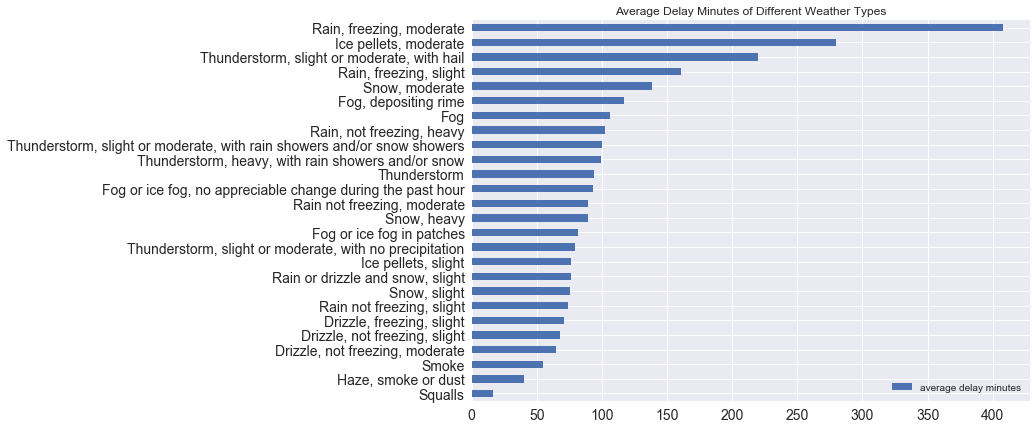

In [33]:
new_avr_df = pd.DataFrame.from_dict(new_avr_dict, orient='index', columns=['average delay minutes']).sort_values(by='average delay minutes')
new_avr_df.plot(kind='barh', title='Average Delay Minutes of Different Weather Types', figsize=(10,7), fontsize=14)

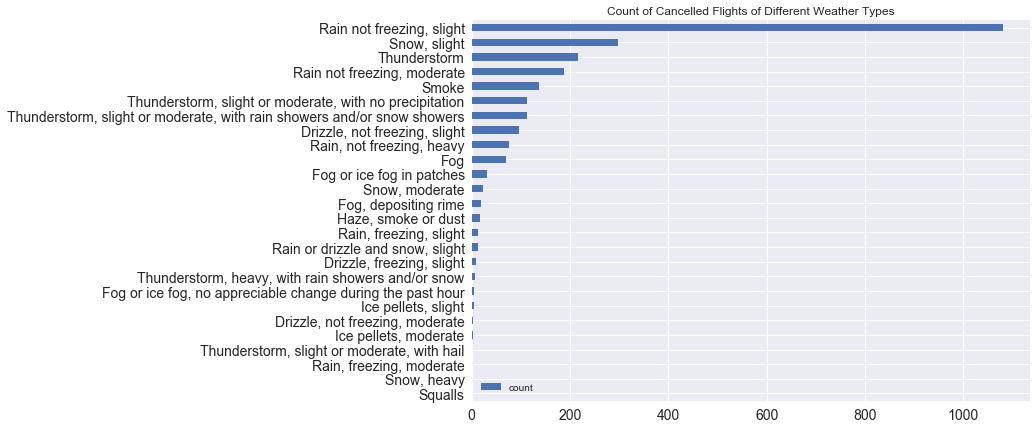

In [34]:
new_res_df = pd.DataFrame.from_dict(new_res_dict, orient='index', columns=['count']).sort_values(by='count')
new_res_df.plot(kind='barh', title='Count of Cancelled Flights of Different Weather Types', figsize=(10,7), fontsize=14)

In [ ]:
# generate delay_and_weather_type.csv
weather_delay_df = pd.concat([new_res_df, new_avr_df], axis=1).sort_values(by='average delay minutes', ascending=False).reset_index()
weather_delay_df = weather_delay_df.rename(columns={'index': 'weather_type'})
weather_delay_df.to_csv('../Weather Data/data/delay_and_weather_type.csv', index=False)

# Delay / carrier and/or aircraft correlation


In [4]:
tail_num_df = pd.read_csv('../tail_num/tail_num_with_number_of_seats.csv')

In [92]:
df = df.merge(tail_num_df.iloc[:, :-1], left_on='TAIL_NUM', right_on='tail_num', how='inner')

In [5]:
delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)

In [6]:
# For delayed flights
# delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
# delayed_flight = df[(df['CARRIER_DELAY'] > 0) & (df['DEP_DELAY'] > 15)].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = delayed_flight['FL_DATE']
df_flight_time['time'] = delayed_flight['CRS_DEP_TIME']
df_flight_time['tail_num'] = delayed_flight['TAIL_NUM']
df_flight_time['delay'] = delayed_flight['DEP_DELAY']
df_flight_time['carrier'] = delayed_flight['OP_CARRIER']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(tail_num_df.iloc[:, :-1], on='tail_num', how='inner')
df_flight_time['age'] = df_flight_time['datetime'].dt.year - df_flight_time['year']

In [7]:
df['age'] = df['YEAR'] - df['year']

In [133]:
delayed_flight.loc[5, 'DEP_DELAY']

17.0

In [140]:
delayed_flight.head(10).iloc[:, 25:45]

DEST_STATE_ABR  DEST_STATE_FIPS   DEST_STATE_NM  DEST_WAC  CRS_DEP_TIME  \
0             FL               12         Florida        33          2155   
1             NC               37  North Carolina        36          1130   
2             NC               37  North Carolina        36          1100   
3             KY               21        Kentucky        52          1645   
4             GA               13         Georgia        34          1645   
5             MN               27       Minnesota        63          1105   
6             NV               32          Nevada        85          1425   
7             WA               53      Washington        93          1735   
8             MN               27       Minnesota        63           840   
9             NY               36        New York        22          1906   

   DEP_TIME  DEP_DELAY  DEP_DELAY_NEW  DEP_DEL15  DEP_DELAY_GROUP  \
0    2221.0       26.0           26.0        1.0              1.0   
1    1214.0       44.0           44.0        1.0              2.0   
2    1144.0       44.0           44.0        1.0              2.0   
3    1709.0       24.0           24.0        1.0              1.0   
4    1721.0       36.0           36.0        1.0              2.0   
5    1122.0       17.0           17.0        1.0              1.0   
6    1445.0       20.0           20.0        1.0              1.0   
7    1907.0       92.0           92.0        1.0              6.0   
8     857.0       17.0           17.0        1.0              1.0   
9    1932.0       26.0           26.0        1.0              1.0   

  DEP_TIME_BLK  TAXI_OUT  WHEELS_OFF  WHEELS_ON  TAXI_IN  CRS_ARR_TIME  \
0    2100-2159      17.0      2238.0      522.0      3.0           522   
1    1100-1159      43.0      1257.0     2007.0      4.0          1915   
2    1100-1159      45.0      1229.0     1943.0      4.0          1845   
3    1600-1659      17.0      1726.0     2359.0      3.0          2352   
4    1600-1659      32.0      1753.0       26.0      6.0          2353   
5    1100-1159      28.0      1150.0     1640.0      4.0          1627   
6    1400-1459      10.0      1455.0     1537.0      4.0          1550   
7    1700-1759      35.0      1942.0     2055.0      4.0          1923   
8    0800-0859      14.0       911.0      946.0      5.0           955   
9    1900-1959      26.0      1958.0     2232.0      7.0          2211   

   ARR_TIME  ARR_DELAY  ARR_DELAY_NEW  ARR_DEL15  
0     525.0        3.0            3.0        0.0  
1    2011.0       56.0           56.0        1.0  
2    1947.0       62.0           62.0        1.0  
3       2.0       10.0           10.0        0.0  
4      32.0       39.0           39.0        1.0  
5    1644.0       17.0           17.0        1.0  
6    1541.0       -9.0            0.0        0.0  
7    2059.0       96.0           96.0        1.0  
8     951.0       -4.0            0.0        0.0  
9    2239.0       28.0           28.0        1.0

In [138]:
delayed_flight.head(10).iloc[:, 56:61]

CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0            NaN            NaN        NaN             NaN   
1            0.0           21.0       12.0             0.0   
2           12.0            0.0       18.0             0.0   
3            NaN            NaN        NaN             NaN   
4            2.0            0.0        3.0             0.0   
5           17.0            0.0        0.0             0.0   
6            NaN            NaN        NaN             NaN   
7           92.0            0.0        4.0             0.0   
8            NaN            NaN        NaN             NaN   
9            0.0            0.0       28.0             0.0   

   LATE_AIRCRAFT_DELAY  
0                  NaN  
1                 23.0  
2                 32.0  
3                  NaN  
4                 34.0  
5                  0.0  
6                  NaN  
7                  0.0  
8                  NaN  
9                  0.0

In [147]:
delayed_flight.iloc[14164, 25:45]

DEST_STATE_ABR            FL
DEST_STATE_FIPS           12
DEST_STATE_NM        Florida
DEST_WAC                  33
CRS_DEP_TIME            1530
DEP_TIME                1759
DEP_DELAY                149
DEP_DELAY_NEW            149
DEP_DEL15                  1
DEP_DELAY_GROUP            9
DEP_TIME_BLK       1500-1559
TAXI_OUT                  48
WHEELS_OFF              1847
WHEELS_ON               2114
TAXI_IN                    5
CRS_ARR_TIME            1906
ARR_TIME                2119
ARR_DELAY                133
ARR_DELAY_NEW            133
ARR_DEL15                  1
Name: 14164, dtype: object

In [142]:
delayed_flight[delayed_flight['SECURITY_DELAY'] > 0].iloc[:, 56:61]

CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
1007               0.0            0.0        0.0            31.0   
1192               0.0            0.0       38.0            37.0   
2996               0.0            0.0        0.0           121.0   
3396               0.0            0.0       21.0            62.0   
4441               0.0            0.0        0.0           182.0   
5131               0.0            0.0        0.0           118.0   
5718               0.0            0.0        0.0            24.0   
6221               0.0            0.0        0.0            33.0   
8498               0.0            0.0        0.0            57.0   
9862               0.0            0.0        9.0            42.0   
10049              0.0            0.0        0.0            39.0   
10587              0.0            0.0        0.0            41.0   
12389              0.0            0.0        0.0           110.0   
13317              0.0            0.0        0.0           137.0   
13840             76.0            0.0        0.0            88.0   
14164              0.0            0.0        0.0            78.0   
18965             54.0            0.0        3.0            54.0   
24379              0.0            0.0        0.0            80.0   
26094              0.0            0.0        0.0            30.0   
26384              0.0            0.0        0.0            44.0   
28592              0.0            0.0        0.0           124.0   
28664              0.0            0.0        0.0            47.0   
28898              0.0            0.0        0.0            29.0   
31922              0.0            0.0        0.0            25.0   
36415              0.0            0.0        0.0            19.0   
37378              0.0            0.0        9.0            50.0   
39179              0.0            0.0       18.0            75.0   
40079              0.0            0.0        0.0            39.0   
41683              0.0            0.0       13.0            48.0   
43719              0.0            0.0        9.0            35.0   
...                ...            ...        ...             ...   
1889545            0.0            0.0        0.0            71.0   
1889915            0.0            0.0        8.0            19.0   
1890153            0.0            0.0        7.0            28.0   
1890207            0.0            0.0        7.0            29.0   
1890338            0.0            0.0        0.0             6.0   
1890365            0.0            0.0        0.0            25.0   
1890463            0.0            0.0        6.0            19.0   
1890475            0.0            0.0        6.0            54.0   
1890537            0.0            0.0        0.0            17.0   
1893054            0.0            0.0        0.0            32.0   
1893110            0.0            0.0        5.0            20.0   
1893229            0.0            0.0        0.0            15.0   
1893242            0.0            0.0        0.0             3.0   
1893259            0.0            0.0        0.0            13.0   
1893596            0.0            0.0        0.0           209.0   
1893782            0.0            0.0        0.0            11.0   
1893817            0.0            0.0        0.0           102.0   
1893832            0.0            0.0        0.0            15.0   
1894074            0.0            0.0       22.0             9.0   
1894148            0.0            0.0        0.0             4.0   
1895440            0.0            0.0        0.0            22.0   
1895929            0.0            0.0        0.0           132.0   
1895988            0.0            0.0        0.0            19.0   
1896247            0.0            0.0        8.0            48.0   
1896330            0.0            0.0        0.0            52.0   
1897353            0.0            0.0       22.0            39.0   
1897541            0.0            0.0        0.0            11.0 

In [111]:
delayed_flight.columns.values

array(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID',
       'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS',
       'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
       'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED',
       'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTAN

## Delay to plane age

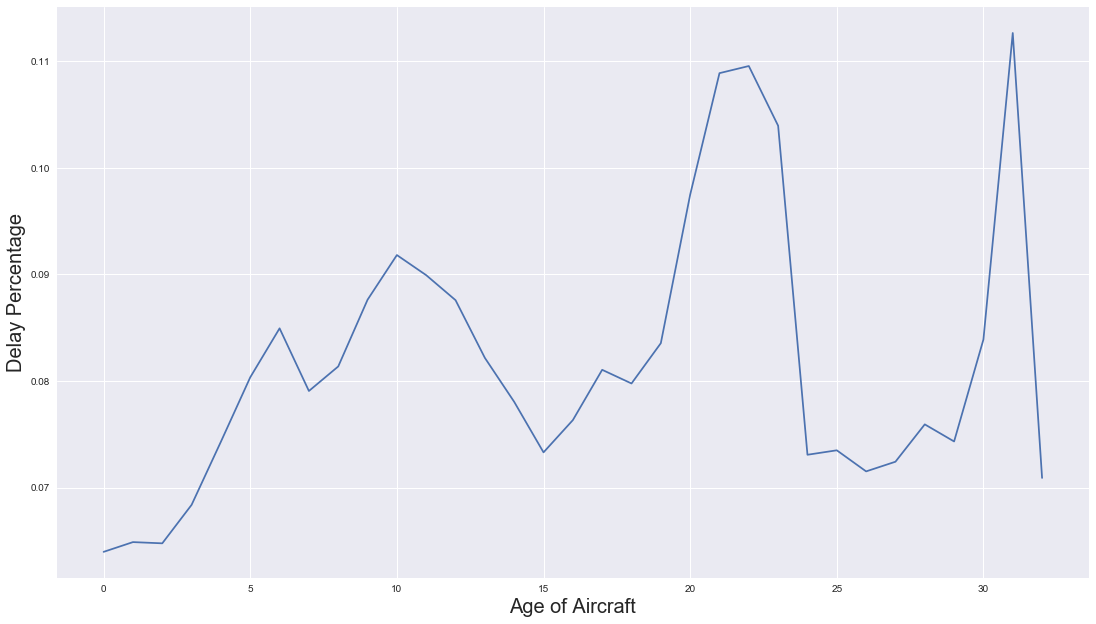

In [174]:
all_flights_age_count = np.array(df.groupby('age').DEP_DELAY.count().tolist()[1:])
delay_flights_age_count = np.array(df_flight_time.groupby('age').delay.count().tolist()[1:])
plt.plot(range(0,33), delay_flights_age_count / all_flights_age_count)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

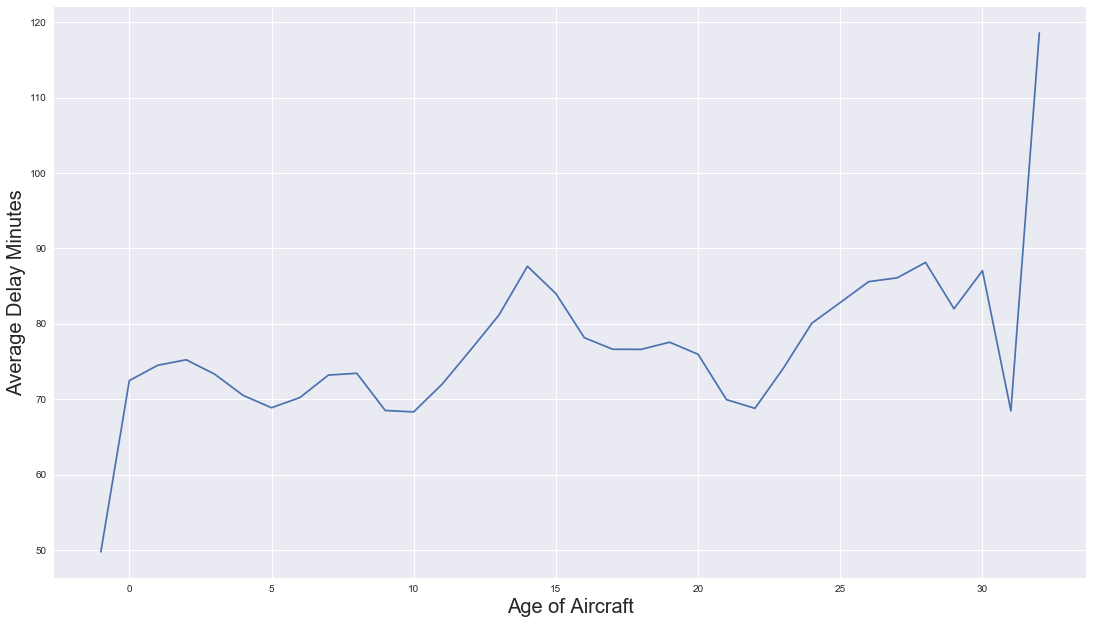

In [184]:
delayed_flight_age = delayed_flight.groupby('age').DEP_DELAY.mean()
plt.plot(delayed_flight_age.index, delayed_flight_age.values)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to carrier

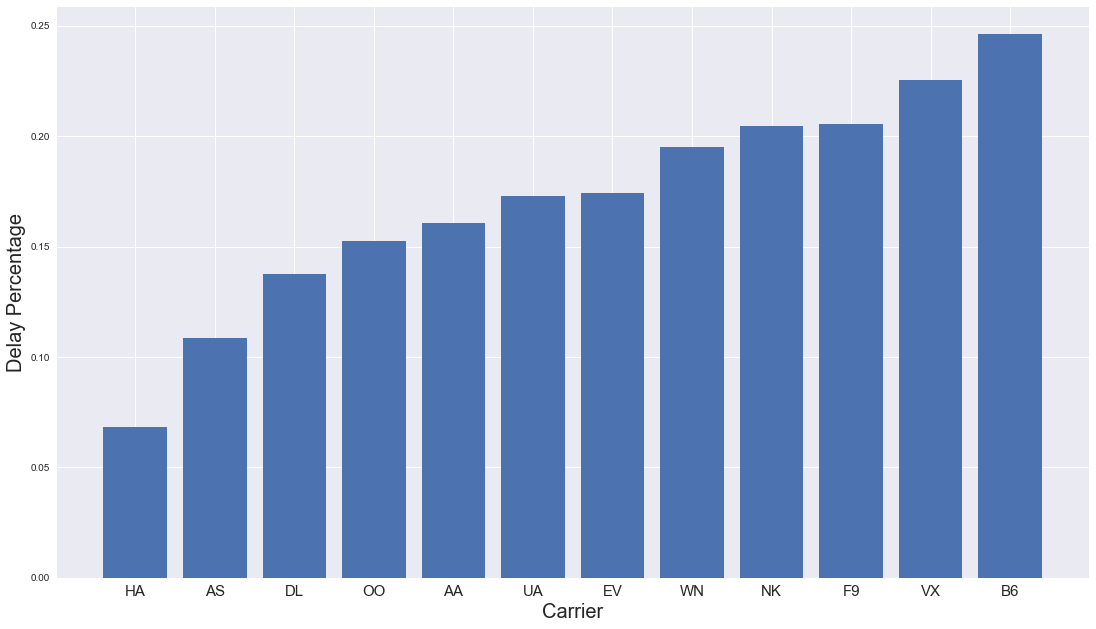

In [109]:
all_flights_carrier_count = np.array(df.groupby('OP_CARRIER').DEP_DELAY.count().tolist())
delay_flights_carrier_count = np.array(df_flight_time.groupby('carrier').delay.count().tolist())
carrier_names = df.groupby('OP_CARRIER').DEP_DELAY.count().index.tolist()
carrier_delay_percentage = pd.DataFrame(delay_flights_carrier_count / all_flights_carrier_count, index=carrier_names, columns=['delay_percentage'])
carrier_delay_percentage = carrier_delay_percentage.sort_values(by='delay_percentage')
plt.bar(carrier_delay_percentage.index, carrier_delay_percentage.delay_percentage)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

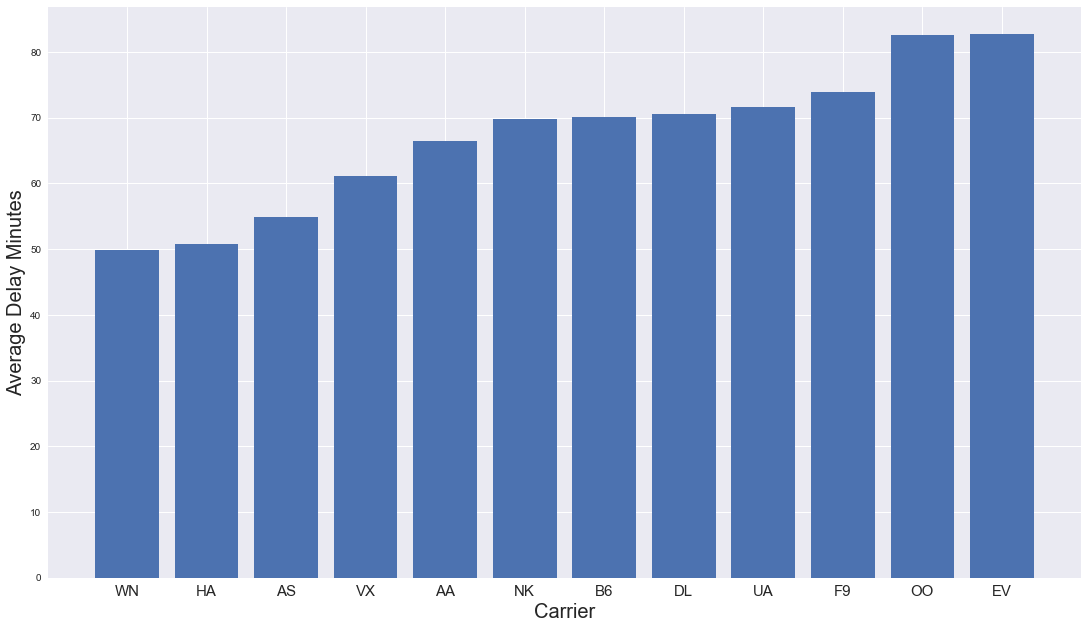

In [108]:
delayed_flight_carrier = delayed_flight.groupby('OP_CARRIER').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_carrier.index, delayed_flight_carrier.values)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to plane manufacturer

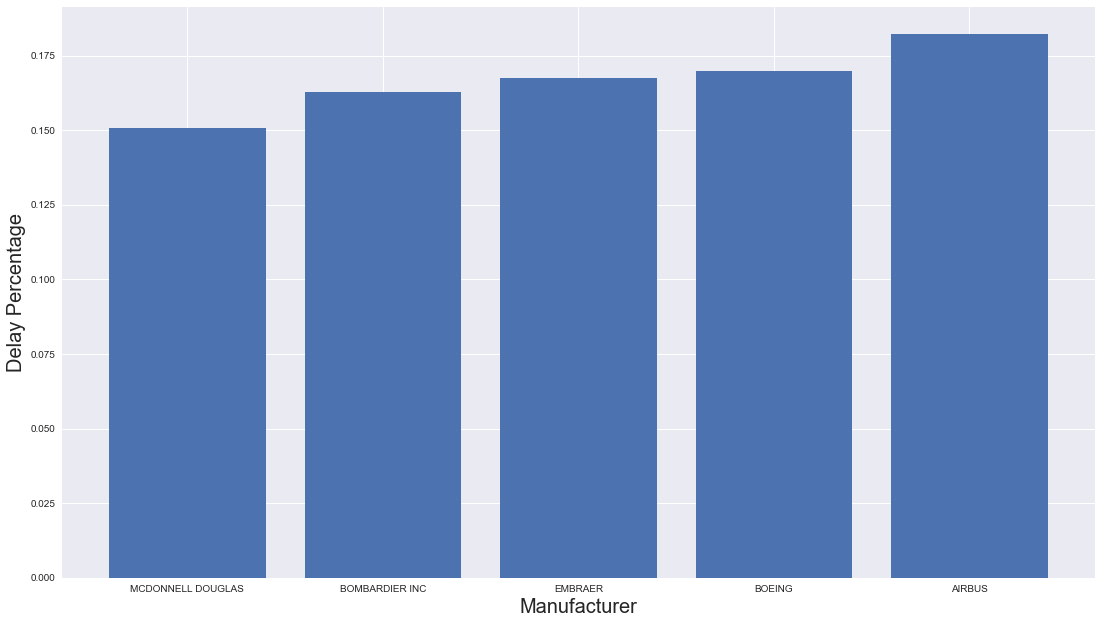

In [104]:
all_flights_mfr_count = np.array(df.groupby('mfr_name').DEP_DELAY.count().tolist())
delay_flights_mfr_count = np.array(df_flight_time.groupby('mfr_name').delay.count().tolist())
mfr_names = df.groupby('mfr_name').DEP_DELAY.count().index.tolist()
mfr_delay_percentage = pd.DataFrame(delay_flights_mfr_count / all_flights_mfr_count, index=mfr_names, columns=['delay_percentage'])
mfr_delay_percentage = mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(mfr_delay_percentage.index, mfr_delay_percentage.delay_percentage)
plt.xticks(mfr_delay_percentage.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

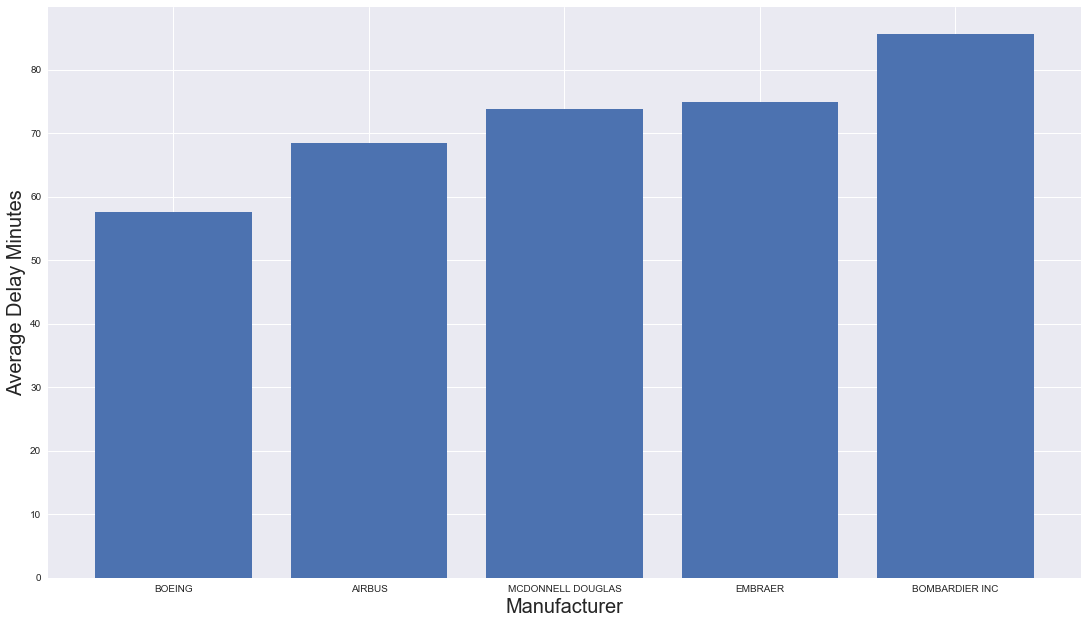

In [105]:
delayed_flight_mfr = delayed_flight.groupby('mfr_name').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_mfr.index, delayed_flight_mfr.values)
plt.xticks(delayed_flight_mfr.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to aircraft model

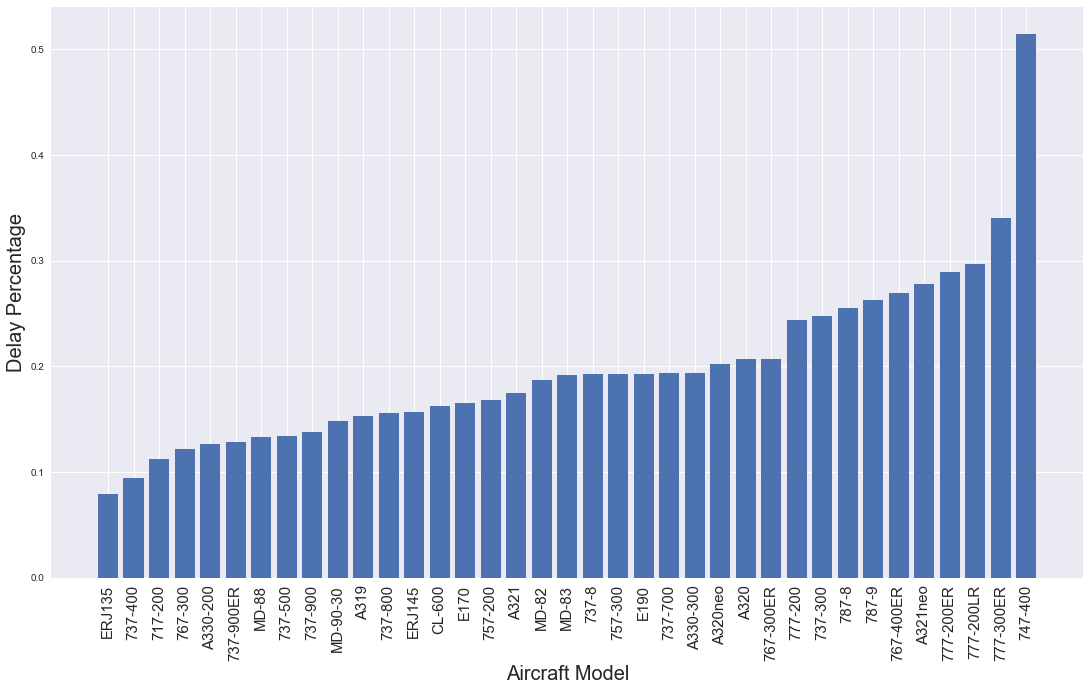

In [82]:
all_flights_model_count = np.array(df.groupby('model_2').DEP_DELAY.count().tolist())
delay_flights_model_count = np.array(df_flight_time.groupby('model_2').delay.count().tolist())
model_names = df.groupby('model_2').DEP_DELAY.count().index.tolist()
model_delay_percentage = pd.DataFrame(delay_flights_model_count / all_flights_model_count, index=model_names, columns=['delay_percentage'])
model_delay_percentage = model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(model_delay_percentage.index, model_delay_percentage.delay_percentage)
plt.xticks(model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

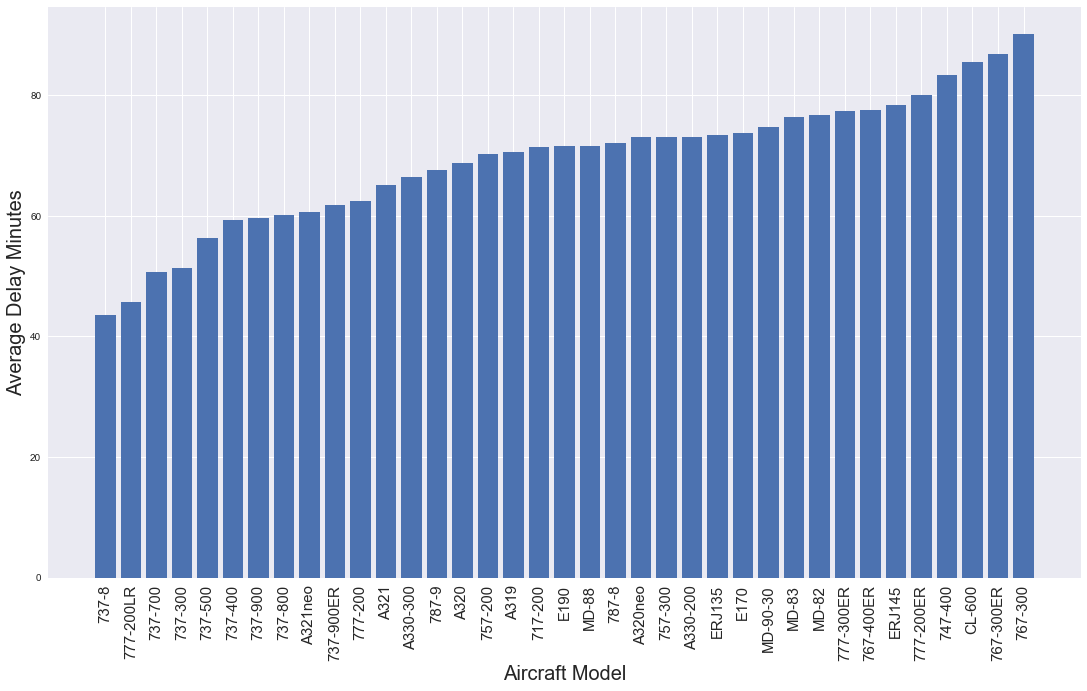

In [5]:
delayed_flight_model = delayed_flight.groupby('model_2').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_model.index, delayed_flight_model.values)
plt.xticks(delayed_flight_model.index, rotation=90, fontsize=15)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to engine manufacturer

Text(0,0.5,'Delay Percentage')

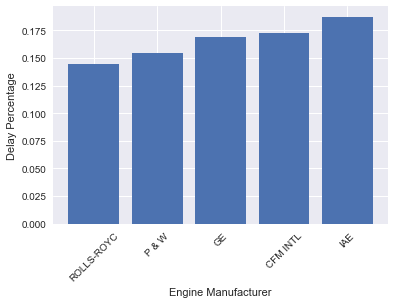

In [87]:
all_flights_eng_mfr_count = np.array(df.groupby('eng_mfr_name').DEP_DELAY.count().tolist())
delay_flights_eng_mfr_count = np.array(df_flight_time.groupby('eng_mfr_name').delay.count().tolist())
eng_mfr_names = df.groupby('eng_mfr_name').DEP_DELAY.count().index.tolist()
eng_mfr_delay_percentage = pd.DataFrame(delay_flights_eng_mfr_count / all_flights_eng_mfr_count, index=eng_mfr_names, columns=['delay_percentage'])
eng_mfr_delay_percentage = eng_mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_mfr_delay_percentage.index, eng_mfr_delay_percentage.delay_percentage)
plt.xticks(eng_mfr_delay_percentage.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Delay Percentage')

Text(0,0.5,'Average Delay Minutes')

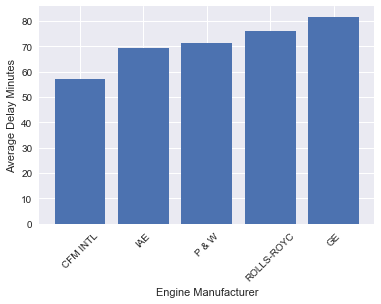

In [88]:
delayed_flight_eng_mfr = delayed_flight.groupby('eng_mfr_name').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_mfr.index, delayed_flight_eng_mfr.values)
plt.xticks(delayed_flight_eng_mfr.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Delay Minutes')

## Delay to engine model

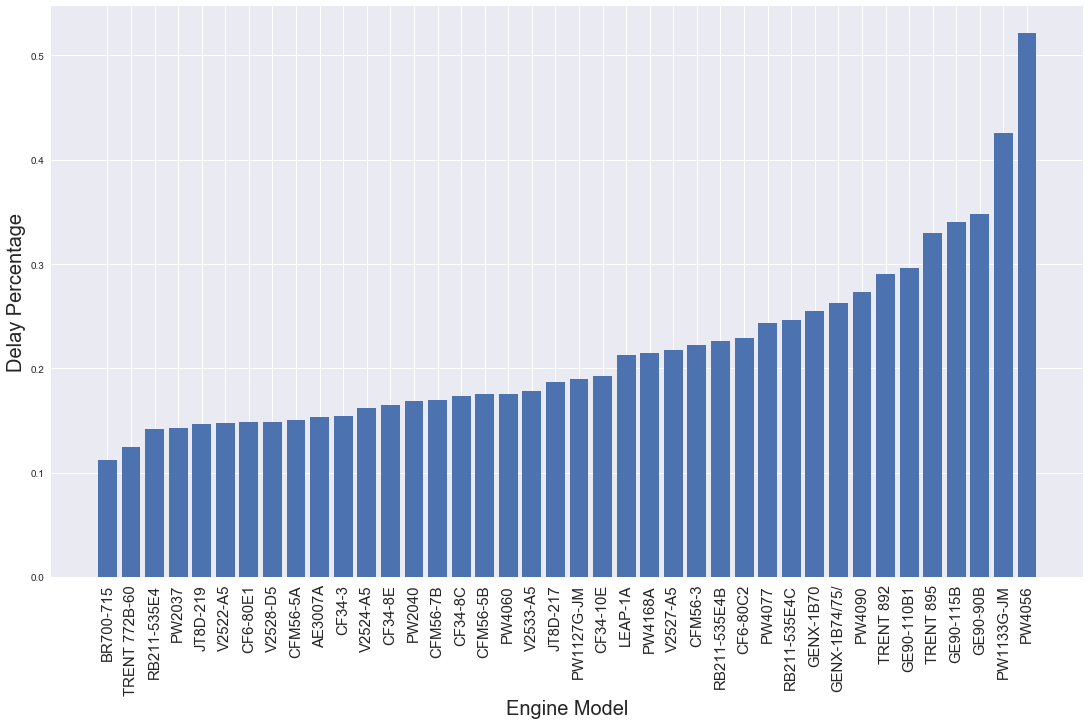

In [90]:
all_flights_eng_model_count = np.array(df.groupby('eng_model').DEP_DELAY.count().tolist())
delay_flights_eng_model_count = np.array(df_flight_time.groupby('eng_model').delay.count().tolist())
eng_model_names = df.groupby('eng_model').DEP_DELAY.count().index.tolist()
eng_model_delay_percentage = pd.DataFrame(delay_flights_eng_model_count / all_flights_eng_model_count, index=eng_model_names, columns=['delay_percentage'])
eng_model_delay_percentage = eng_model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_model_delay_percentage.index, eng_model_delay_percentage.delay_percentage)
plt.xticks(eng_model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

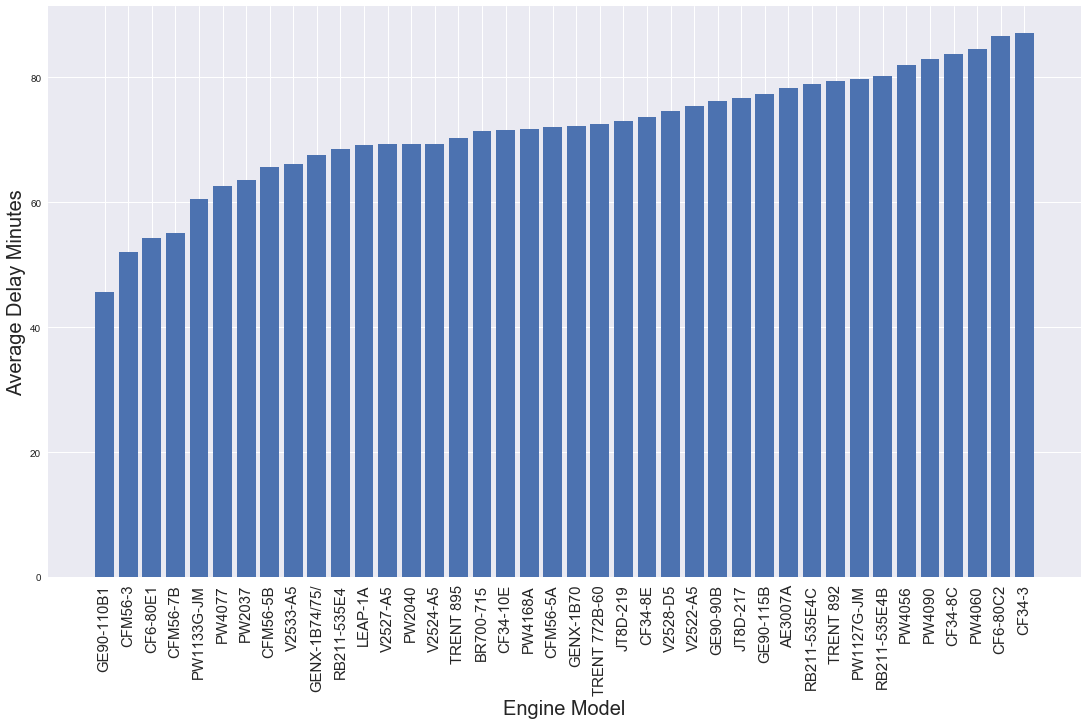

In [92]:
delayed_flight_eng_model = delayed_flight.groupby('eng_model').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_model.index, delayed_flight_eng_model.values)
plt.xticks(delayed_flight_eng_model.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Carrier Delay

In [149]:
# For delayed flights
# delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
delayed_flight = df[(df['CARRIER_DELAY'] > 0) & (df['DEP_DELAY'] > 15)].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = delayed_flight['FL_DATE']
df_flight_time['time'] = delayed_flight['CRS_DEP_TIME']
df_flight_time['tail_num'] = delayed_flight['TAIL_NUM']
df_flight_time['delay'] = delayed_flight['CARRIER_DELAY']
df_flight_time['carrier'] = delayed_flight['OP_CARRIER']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(tail_num_df.iloc[:, :-1], on='tail_num', how='inner')
df_flight_time['age'] = df_flight_time['datetime'].dt.year - df_flight_time['year']

## Carrier Delay to Age

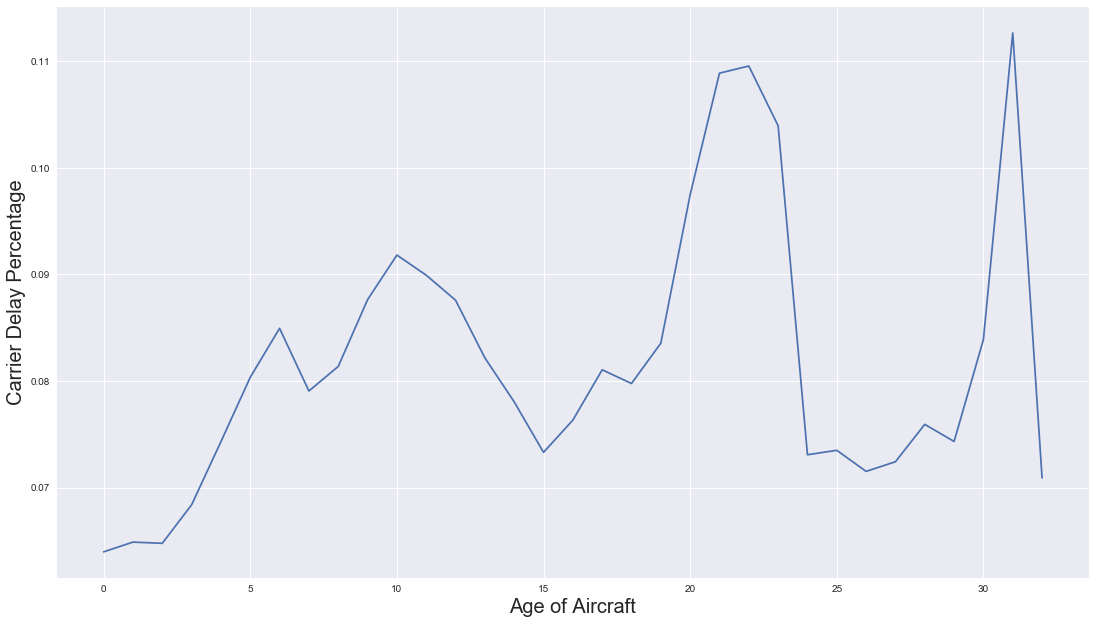

In [185]:
all_flights_age_count = np.array(df.groupby('age').DEP_DELAY.count().tolist()[1:])
delay_flights_age_count = np.array(df_flight_time.groupby('age').delay.count().tolist()[1:])
plt.plot(range(0,33), delay_flights_age_count / all_flights_age_count)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

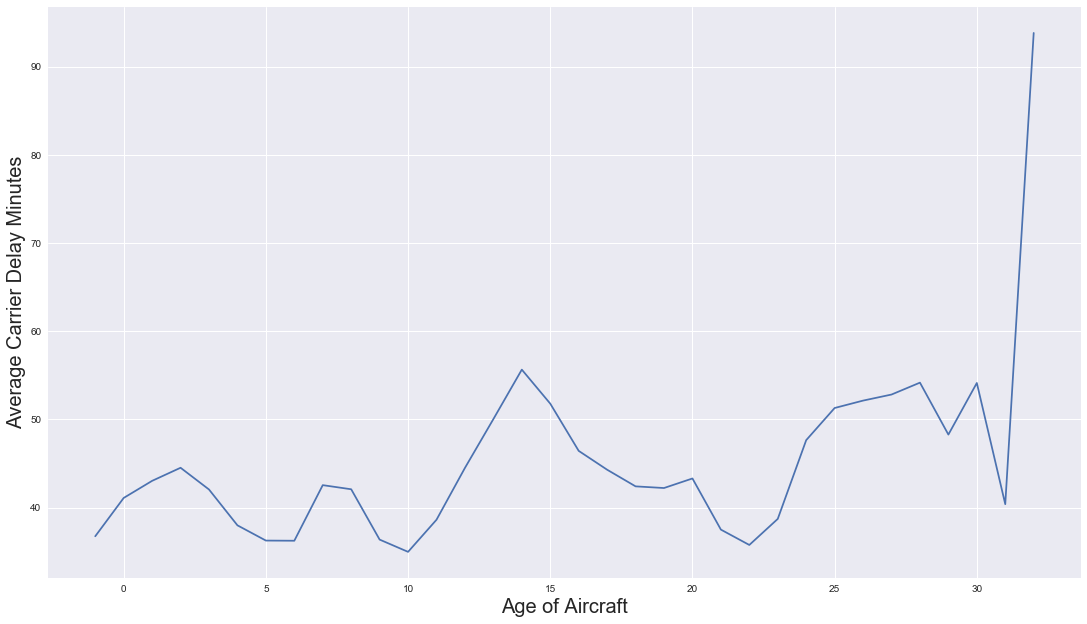

In [186]:
delayed_flight_age = delayed_flight.groupby('age').CARRIER_DELAY.mean()
plt.plot(delayed_flight_age.index, delayed_flight_age.values)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to carrier

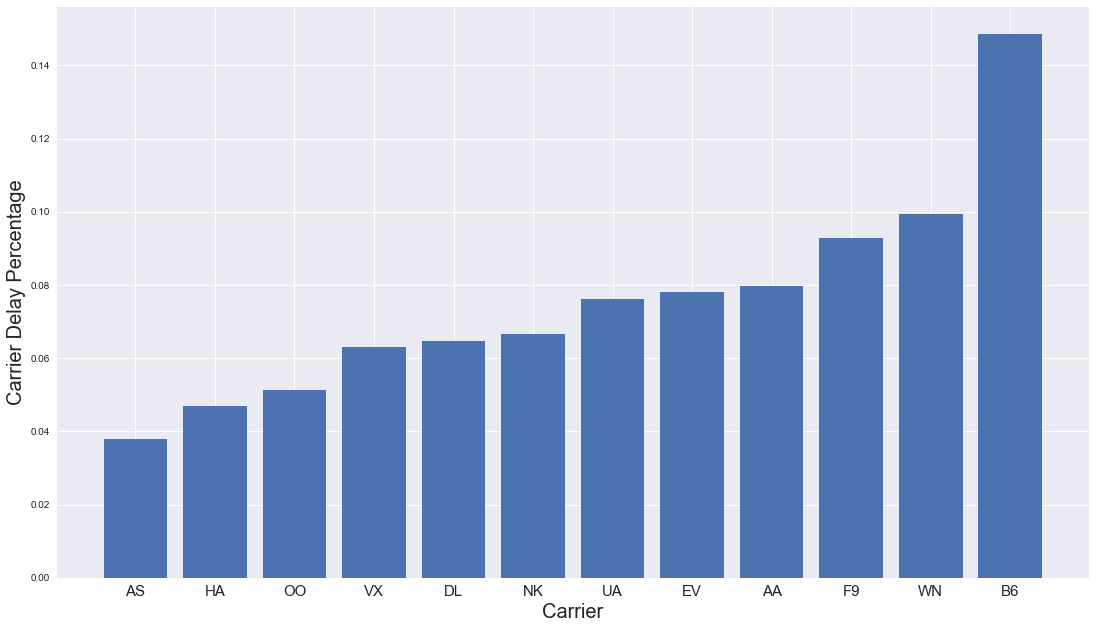

In [157]:
all_flights_carrier_count = np.array(df.groupby('OP_CARRIER').DEP_DELAY.count().tolist())
delay_flights_carrier_count = np.array(df_flight_time.groupby('carrier').delay.count().tolist())
carrier_names = df.groupby('OP_CARRIER').CARRIER_DELAY.count().index.tolist()
carrier_delay_percentage = pd.DataFrame(delay_flights_carrier_count / all_flights_carrier_count, index=carrier_names, columns=['delay_percentage'])
carrier_delay_percentage = carrier_delay_percentage.sort_values(by='delay_percentage')
plt.bar(carrier_delay_percentage.index, carrier_delay_percentage.delay_percentage)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

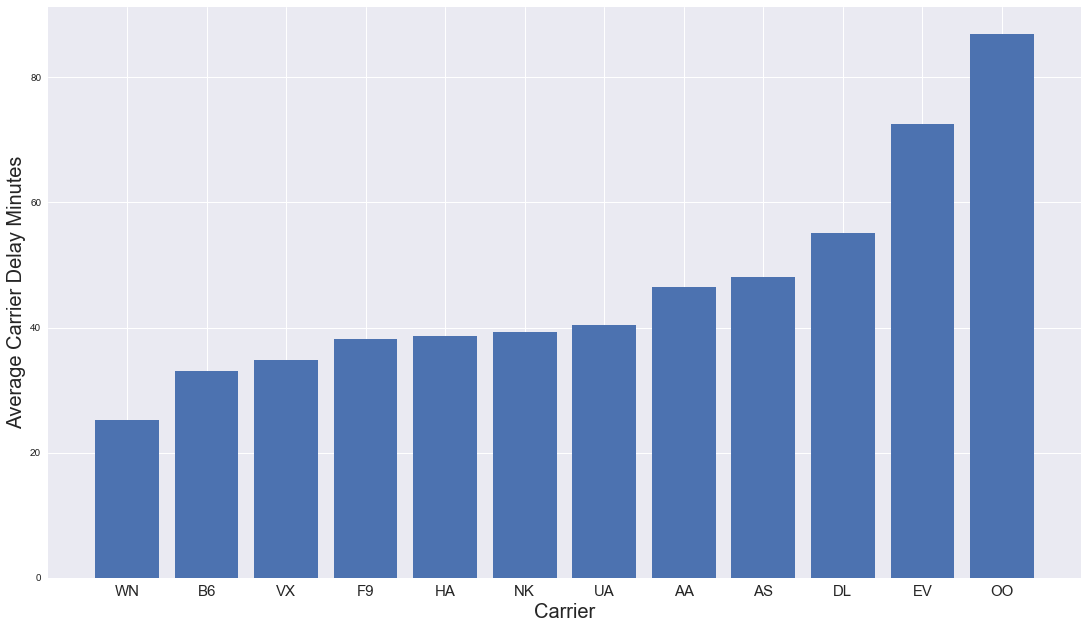

In [158]:
delayed_flight_carrier = delayed_flight.groupby('OP_CARRIER').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_carrier.index, delayed_flight_carrier.values)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to plane manufacturer

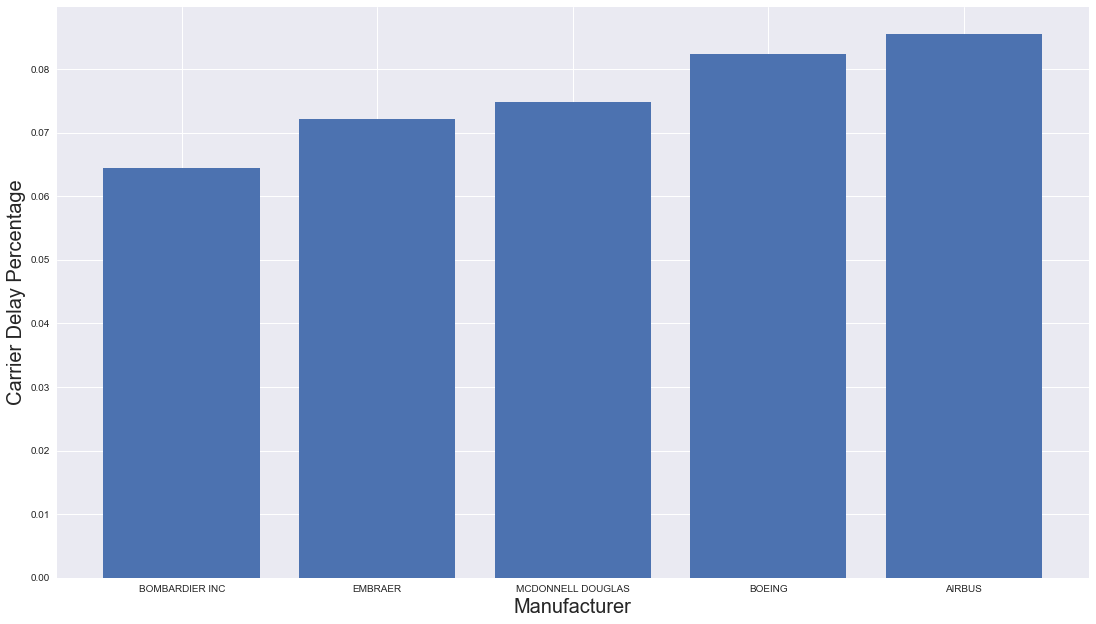

In [163]:
all_flights_mfr_count = np.array(df.groupby('mfr_name').DEP_DELAY.count().tolist())
delay_flights_mfr_count = np.array(df_flight_time.groupby('mfr_name').delay.count().tolist())
mfr_names = df.groupby('mfr_name').DEP_DELAY.count().index.tolist()
mfr_delay_percentage = pd.DataFrame(delay_flights_mfr_count / all_flights_mfr_count, index=mfr_names, columns=['delay_percentage'])
mfr_delay_percentage = mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(mfr_delay_percentage.index, mfr_delay_percentage.delay_percentage)
plt.xticks(mfr_delay_percentage.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

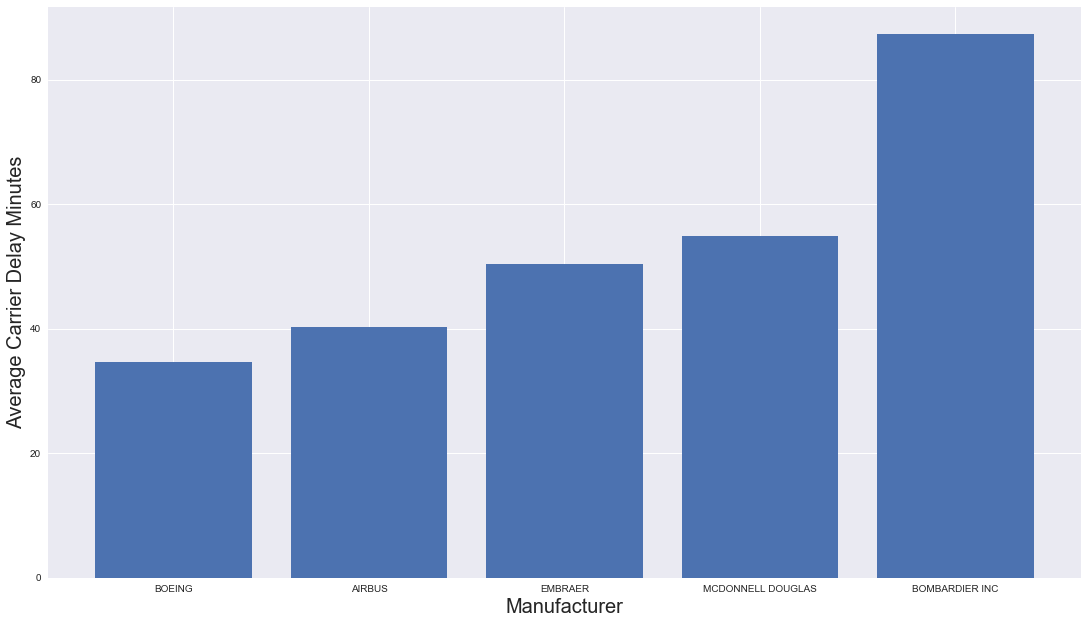

In [162]:
delayed_flight_mfr = delayed_flight.groupby('mfr_name').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_mfr.index, delayed_flight_mfr.values)
plt.xticks(delayed_flight_mfr.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to aircraft model

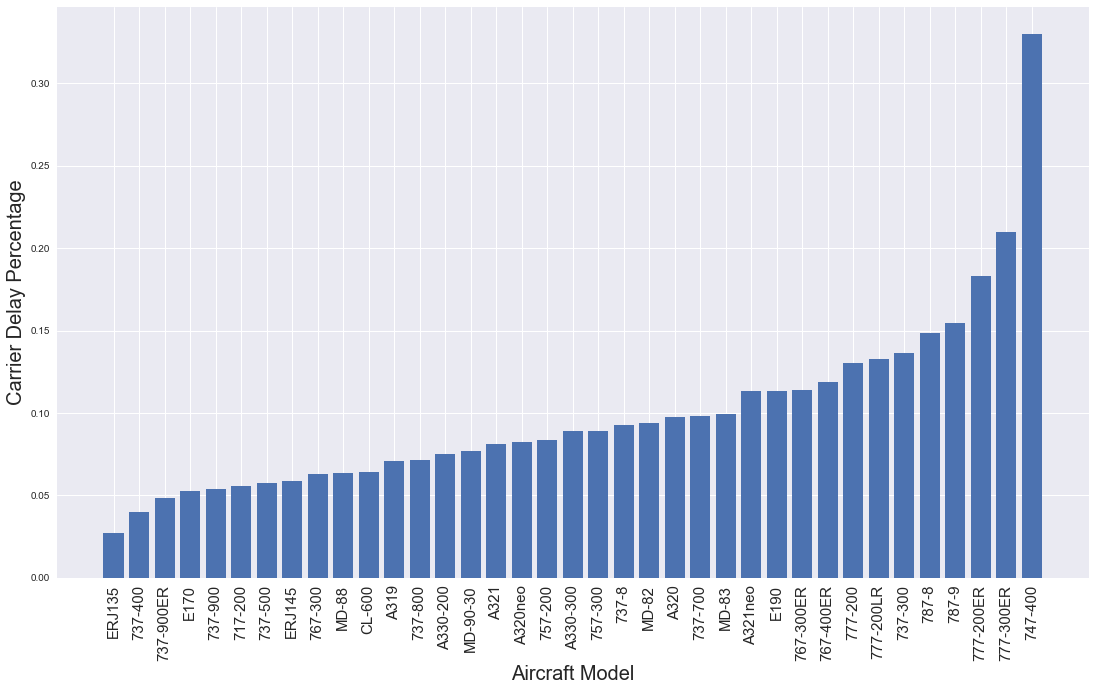

In [164]:
all_flights_model_count = np.array(df.groupby('model_2').DEP_DELAY.count().tolist())
delay_flights_model_count = np.array(df_flight_time.groupby('model_2').delay.count().tolist())
model_names = df.groupby('model_2').DEP_DELAY.count().index.tolist()
model_delay_percentage = pd.DataFrame(delay_flights_model_count / all_flights_model_count, index=model_names, columns=['delay_percentage'])
model_delay_percentage = model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(model_delay_percentage.index, model_delay_percentage.delay_percentage)
plt.xticks(model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

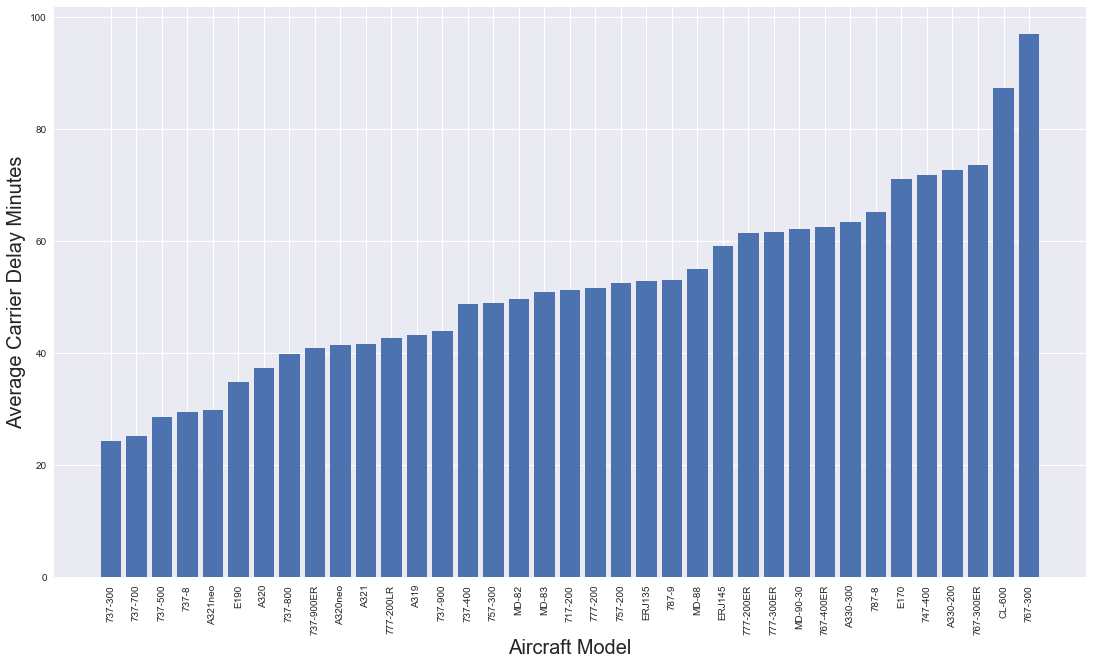

In [165]:
delayed_flight_model = delayed_flight.groupby('model_2').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_model.index, delayed_flight_model.values)
plt.xticks(delayed_flight_model.index, rotation=90)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to engine manufacturer

Text(0,0.5,'Carrier Delay Percentage')

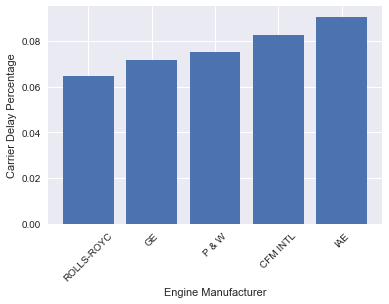

In [166]:
all_flights_eng_mfr_count = np.array(df.groupby('eng_mfr_name').DEP_DELAY.count().tolist())
delay_flights_eng_mfr_count = np.array(df_flight_time.groupby('eng_mfr_name').delay.count().tolist())
eng_mfr_names = df.groupby('eng_mfr_name').DEP_DELAY.count().index.tolist()
eng_mfr_delay_percentage = pd.DataFrame(delay_flights_eng_mfr_count / all_flights_eng_mfr_count, index=eng_mfr_names, columns=['delay_percentage'])
eng_mfr_delay_percentage = eng_mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_mfr_delay_percentage.index, eng_mfr_delay_percentage.delay_percentage)
plt.xticks(eng_mfr_delay_percentage.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Carrier Delay Percentage')

Text(0,0.5,'Average Carrier Delay Minutes')

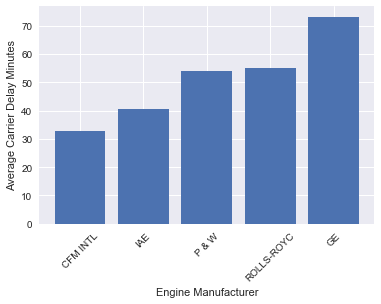

In [167]:
delayed_flight_eng_mfr = delayed_flight.groupby('eng_mfr_name').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_mfr.index, delayed_flight_eng_mfr.values)
plt.xticks(delayed_flight_eng_mfr.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Carrier Delay Minutes')

## Carrier Delay to engine model

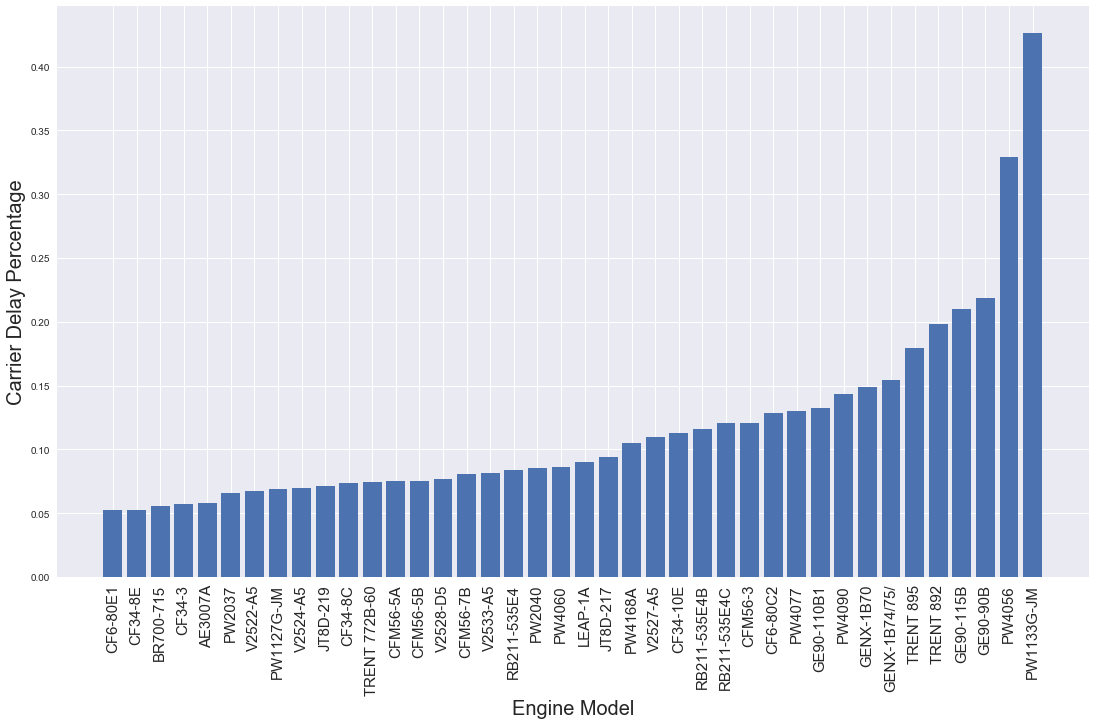

In [168]:
all_flights_eng_model_count = np.array(df.groupby('eng_model').DEP_DELAY.count().tolist())
delay_flights_eng_model_count = np.array(df_flight_time.groupby('eng_model').delay.count().tolist())
eng_model_names = df.groupby('eng_model').DEP_DELAY.count().index.tolist()
eng_model_delay_percentage = pd.DataFrame(delay_flights_eng_model_count / all_flights_eng_model_count, index=eng_model_names, columns=['delay_percentage'])
eng_model_delay_percentage = eng_model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_model_delay_percentage.index, eng_model_delay_percentage.delay_percentage)
plt.xticks(eng_model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

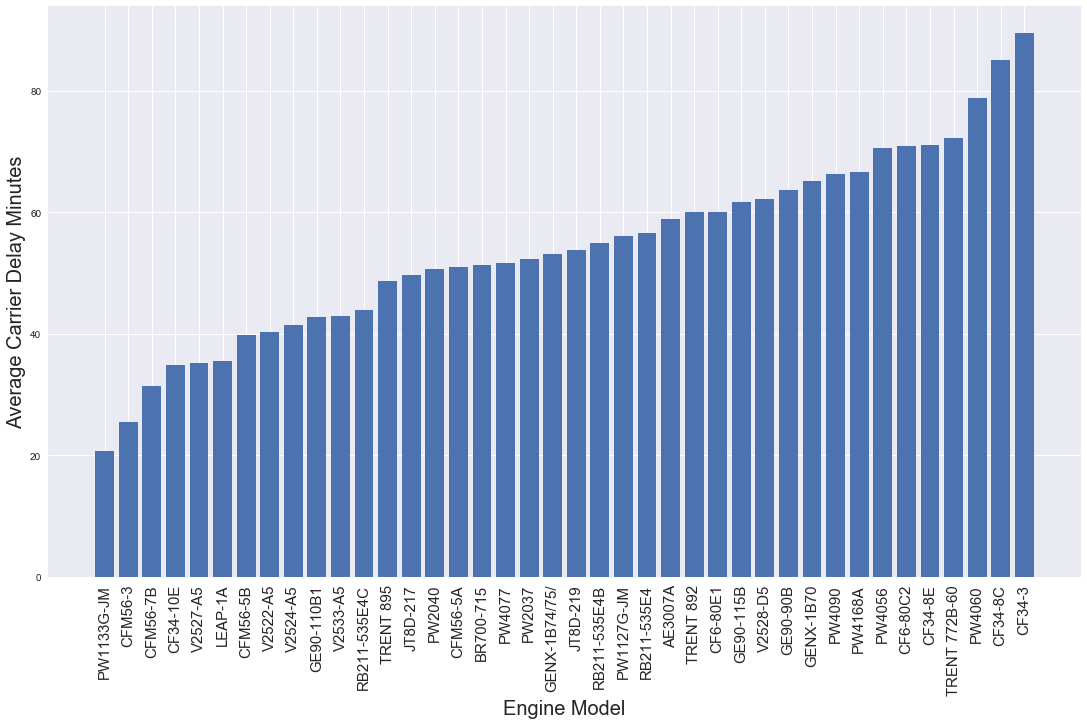

In [169]:
delayed_flight_eng_model = delayed_flight.groupby('eng_model').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_model.index, delayed_flight_eng_model.values)
plt.xticks(delayed_flight_eng_model.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Delayed flights on US map

# Calculate delay percentage for airports

In [2]:
from mpl_toolkits.basemap import Basemap as Basemap

In [134]:
stations_df = pd.read_csv('./airport_location.csv')

In [3]:
delay_percentage = pd.read_csv('airport_delay.csv')
delay_percentage['delay_percentage'] = delay_percentage['delay_count'] / delay_percentage['total_count']

In [5]:
delay_percentage['delay_expect'] = delay_percentage['delay_percentage'] * delay_percentage['avr_delay']

In [8]:
delay_percentage.sort_values(by='avr_delay', ascending=False)

origin  all_avr_delay   avr_delay  total_count  delay_count   WBAN  \
320    PPG      31.171548  339.888889          239         27.0  61705   
307    GCK      16.800333  170.354430          601         79.0  23064   
323    ENV     157.000000  157.000000            1          1.0  24193   
69     BTM       5.358377  147.103093         1331         97.0  24135   
305    CIU      16.433807  145.610465         1337        172.0   4869   
287    MQT      13.456885  143.193069         1554        202.0  94836   
31     HLN       2.068522  134.900585         3342        171.0  24144   
14     LWS      -1.487705  134.061538         1464         65.0  24149   
85     INL       6.061538  132.950000         1235        120.0  14918   
271    CMX      12.294760  130.105556         1374        180.0  14858   
78     RHI       5.715831  129.994413         1756        179.0   4803   
152    MOT       8.141083  128.733945         3140        327.0  24013   
55     LCH       4.262876  127.240000         2427        225.0   3937   
268    MHK      12.122517  124.717557          906        131.0   3936   
229    IMT      10.419355  124.465839         1333        161.0  94893   
311    MEI      19.140168  123.582547         2019        424.0  13865   
58     COU       4.640065  122.312500          614         48.0   3945   
37     EKO       2.539422  122.011765         1281         85.0  24121   
233    DLH      10.590298  120.688207         4906        619.0  14913   
72     HIB       5.467732  119.325714         1627        175.0  94931   
301    APN      15.429383  119.177419         1232        186.0  94849   
60     ISN       4.840730  118.834586         2794        266.0  94014   
136    ABR       7.628611  118.623077         1454        130.0  14929   
103    EAU       6.773002  118.094488         1326        127.0  14991   
240    PLN      10.805720  117.756098         2028        287.0  14841   
39     GTF       2.909384  117.212766         3410        235.0  24143   
33     RKS       2.151655  116.273810         1299         84.0  24027   
36     GCC       2.366469  115.807229         2022        166.0  94023   
83     BRD       5.950158  115.292453         1264        106.0  94938   
257    AVP      11.563804  115.002288         3354        437.0  14777   
..     ...            ...         ...          ...          ...    ...   
186    DEN       8.984233   59.725892       444910      77984.0   3017   
140    ABQ       7.878697   59.691115        37765       5999.0  23050   
289    HYA      13.579439   59.574074          214         54.0  94720   
82     PDX       5.949192   59.480733       120492      16816.0  24229   
269    LAX      12.156352   58.847778       423403      94651.0  23174   
134    SAN       7.616014   58.770595       160485      25662.0  23188   
227    LAS      10.368521   57.991228       299839      59277.0  23169   
148    BUR       8.075867   56.913168        46819       8027.0  23152   
190    STL       9.021185   56.734600       111401      19951.0  13994   
91     SEA       6.309540   56.733105       268521      39124.0  24233   
108    SNA       6.921132   56.355695        83557      13028.0  93184   
197    BWI       9.116705   56.288594       193917      34571.0  93721   
159    SMF       8.295806   55.827560        85654      14579.0  93225   
115    PHX       7.087791   54.469830       311890      49005.0  23183   
10     OTZ      -2.533381   53.559701         1393        134.0  26616   
128    SJC       7.438700   52.584858        90424      15361.0  23293   
2      BET      -6.643235   51.672727         1892        110.0  26615   
226    HOU      10.341132   50.404286       106217      21418.0  12918   
221    MDW      10.043900   50.366945       172234      34343.0  14819   
245    DAL      10.978434   49.234554       136926      29571.0  13960   
15     GST      -1.300613   48.000000          163         25.0  25322   
9      OME      -2.710809   47.617021         1397        141.0  26617   
5      D

# Delay by origin airport

In [207]:
# For delayed flights
delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
# delayed_flight = df[(df['CARRIER_DELAY'] > 0) & (df['DEP_DELAY'] > 15)].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['delay'] = delayed_flight['DEP_DELAY']
df_flight_time['origin'] = delayed_flight['ORIGIN']

In [7]:
len(df['ORIGIN'].unique().tolist())

324

In [208]:
delay_flights_origin_count = pd.DataFrame(df_flight_time.groupby('origin').delay.count()).reset_index().rename(columns={'delay': 'delay_count'})
all_flights_origin_count = pd.DataFrame(df.groupby('ORIGIN').DEP_DELAY.count()).reset_index().rename(columns={'DEP_DELAY': 'total_count', 'ORIGIN': 'origin'})

In [209]:
delay_percentage = all_flights_origin_count.merge(delay_flights_origin_count, on='origin', how='left')
delay_percentage = delay_percentage.fillna(0)
delay_percentage = delay_percentage.merge(stations_df, left_on='origin', right_on='IATA', how='left').drop(columns=['IATA'])
delay_percentage['delay_percentage'] = delay_percentage['delay_count'] / delay_percentage['total_count']

In [5]:
delay_percentage = delay_percentage[delay_percentage['total_count'] >= 10]

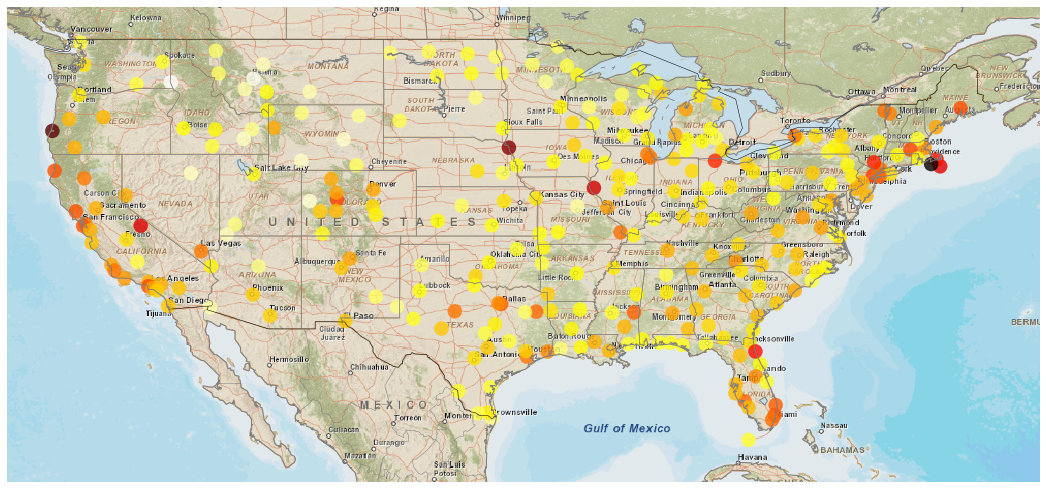

In [99]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['delay_percentage'].values
colors = 1 - size
m = Basemap(llcrnrlon=-127,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95, resolution='l', epsg=4687)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot, alpha=0.8, s=200)
# ax_1 = plt.gca()

# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig = plt.gcf()
fig.set_size_inches(18.5, 12)
# newax = fig.add_axes([0.1, 0.2, 0.2, 0.2], anchor='SW', zorder=10)
# newax.imshow(im)
# newax.axis('off')
plt.show()

In [9]:
from math import log10

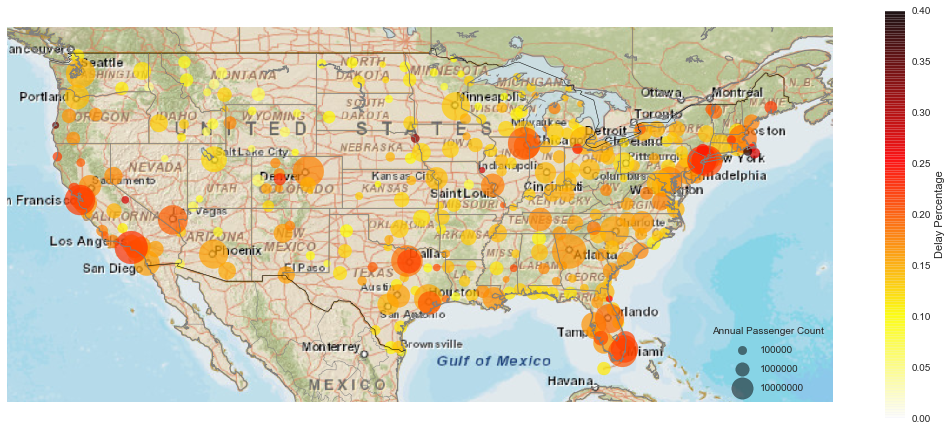

In [14]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-128,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-96, resolution='l', epsg=4687)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size)

plt.colorbar(label=r'Delay Percentage')
plt.clim(0, 0.4)

for a in [50000, 500000, 5000000]:
    plt.scatter([], [], c='k', alpha=0.5, s=2.5 ** log10(a),
                label=str(2*a))
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower right', title='Annual Passenger Count')


fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

plt.show()

In [6]:
from PIL import Image

In [55]:
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll (buf, 3, axis=2)
    return buf

In [56]:
def fig2img(fig):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data(fig)
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w ,h), buf.tostring())

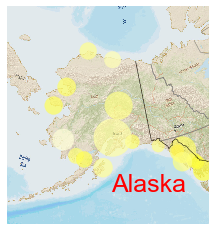

In [16]:
# Alaska
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
# a = plt.axes([.7, .1, .2, .2])
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
# plt.figure(edgecolor='r', linewidth=2)
m = Basemap(llcrnrlon=-170,llcrnrlat=50,urcrnrlon=-110,urcrnrlat=72,
        projection='lcc',lat_1=59,lat_2=66,lon_0=-142, resolution='l', epsg=2964)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 4)
ax_2 = plt.gca()
ax_2.text(.7,.15,'Alaska',
        horizontalalignment='center',
        transform=ax_2.transAxes, color='red', fontsize=25)
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig_2 = plt.gcf()


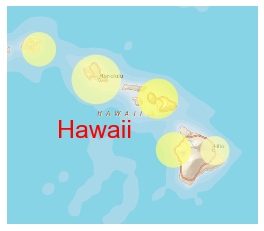

In [17]:
# Hawaii
# df_hawaii = delay_percentage[delay_percentage['STATE'] == 'Hawaii']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-160,llcrnrlat=18,urcrnrlon=-154,urcrnrlat=23,
        projection='lcc',lat_1=19.5,lat_2=22,lon_0=-156, resolution='l', epsg=2782)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=500)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 4)
ax_3 = plt.gca()
ax_3.text(.35,.4,'Hawaii',
        horizontalalignment='center',
        transform=ax_3.transAxes, color='red', fontsize=25)
fig_3 = plt.gcf()

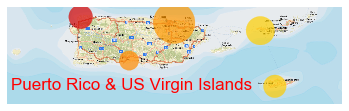

In [18]:
# Puerto Rico & US Virgin Islands
# df_pr = delay_percentage[(delay_percentage['STATE'] == 'Puerto Rico') | (delay_percentage['STATE'] == 'United States Virgin Islands')]
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-68,llcrnrlat=17.5,urcrnrlon=-64,urcrnrlat=18.6,
        projection='lcc',lat_1=18,lat_2=18.5,lon_0=-66, resolution='l', epsg=2866)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 4)
ax_4 = plt.gca()
ax_4.text(.37,.15,'Puerto Rico & US Virgin Islands',
        horizontalalignment='center',
        transform=ax_4.transAxes, color='red', fontsize=17)
fig_4 = plt.gcf()

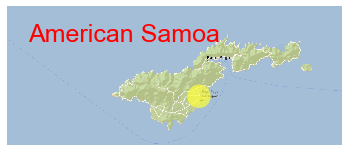

In [19]:
# American Samoa
# df_as = delay_percentage[delay_percentage['STATE'] == 'American Samoa']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-171,llcrnrlat=-14.4,urcrnrlon=-170.5,urcrnrlat=-14.2,
        projection='lcc',lat_1=-14.4,lat_2=-14.2,lon_0=-170.75, resolution='l', epsg=3102)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 100 / 16)
ax_5 = plt.gca()
ax_5.text(.35,.75,'American Samoa',
        horizontalalignment='center',
        transform=ax_5.transAxes, color='red', fontsize=25)
fig_5 = plt.gcf()

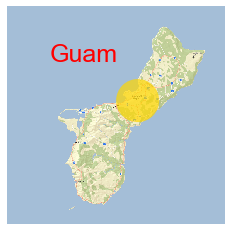

In [20]:
# Guam
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=144.5,llcrnrlat=13.2,urcrnrlon=145,urcrnrlat=13.7,
        projection='lcc',lat_1=13.3,lat_2=13.6,lon_0=144.75, resolution='l', epsg=4675)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 100 / 16)
ax_6 = plt.gca()
ax_6.text(.35,.75,'Guam',
        horizontalalignment='center',
        transform=ax_6.transAxes, color='red', fontsize=25)
fig_6 = plt.gcf()

# Airport Average Delay Minutes

In [290]:
passenger = pd.read_csv('airport_passenger.csv')
passenger.iloc[:, 1] = passenger.iloc[:, 1].str.replace(',','').apply(lambda x: int(x))

In [291]:
passenger = passenger.rename(columns={'17_Enplanements': 'passenger_count'})

In [295]:
avr_delay = avr_delay.merge(passenger, left_on='origin', right_on='IATA', how='left').drop(columns=['IATA'])

In [285]:
all_flights_origin_count = pd.DataFrame(df.groupby('ORIGIN').DEP_DELAY.count()).reset_index().rename(columns={'DEP_DELAY': 'total_count', 'ORIGIN': 'origin'})
delay_flights_origin_count = pd.DataFrame(df_flight_time.groupby('origin').delay.count()).reset_index().rename(columns={'delay': 'delay_count'})

all_flights_average_delay = pd.DataFrame(df.groupby('ORIGIN').DEP_DELAY.mean().sort_values()).reset_index().rename(columns={'DEP_DELAY': 'all_avr_delay', 'ORIGIN': 'origin'})
delay_flights_average_delay = pd.DataFrame(df_flight_time.groupby('origin').delay.mean()).reset_index().rename(columns={'delay': 'avr_delay'})

delay_percentage = all_flights_origin_count.merge(delay_flights_origin_count, on='origin', how='left')
delay_percentage = delay_percentage.fillna(0)

avr_delay = all_flights_average_delay.merge(delay_flights_average_delay, on='origin', how='left')
avr_delay = avr_delay.fillna(0)

avr_delay = avr_delay.merge(delay_percentage, on='origin', how='left')
avr_delay = avr_delay.merge(stations_df, left_on='origin', right_on='IATA', how='left').drop(columns=['IATA'])

In [320]:
avr_delay = avr_delay[avr_delay['total_count'] >= 10]

In [321]:
# set the stations 3 std of avr_day far away mean to mean + 3 std
inx = avr_delay[np.abs(avr_delay.avr_delay - avr_delay.avr_delay.mean()) > (3 * avr_delay.avr_delay.std())].index.tolist()
set_value = avr_delay.avr_delay.mean() + 3 * avr_delay.avr_delay.std()
for i in inx:
    avr_delay.loc[i, 'avr_delay'] = set_value

C:\Users\Qingyu\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [323]:
avr_delay.sort_values(by='avr_delay', ascending=False)

origin  all_avr_delay   avr_delay  total_count  delay_count   WBAN  \
320    PPG      31.171548  162.547586          239         27.0  61705   
307    GCK      16.800333  162.547586          601         79.0  23064   
69     BTM       5.358377  147.103093         1331         97.0  24135   
305    CIU      16.433807  145.610465         1337        172.0   4869   
287    MQT      13.456885  143.193069         1554        202.0  94836   
31     HLN       2.068522  134.900585         3342        171.0  24144   
14     LWS      -1.487705  134.061538         1464         65.0  24149   
85     INL       6.061538  132.950000         1235        120.0  14918   
271    CMX      12.294760  130.105556         1374        180.0  14858   
78     RHI       5.715831  129.994413         1756        179.0   4803   
152    MOT       8.141083  128.733945         3140        327.0  24013   
55     LCH       4.262876  127.240000         2427        225.0   3937   
268    MHK      12.122517  124.717557          906        131.0   3936   
229    IMT      10.419355  124.465839         1333        161.0  94893   
311    MEI      19.140168  123.582547         2019        424.0  13865   
58     COU       4.640065  122.312500          614         48.0   3945   
37     EKO       2.539422  122.011765         1281         85.0  24121   
233    DLH      10.590298  120.688207         4906        619.0  14913   
72     HIB       5.467732  119.325714         1627        175.0  94931   
301    APN      15.429383  119.177419         1232        186.0  94849   
60     ISN       4.840730  118.834586         2794        266.0  94014   
136    ABR       7.628611  118.623077         1454        130.0  14929   
103    EAU       6.773002  118.094488         1326        127.0  14991   
240    PLN      10.805720  117.756098         2028        287.0  14841   
39     GTF       2.909384  117.212766         3410        235.0  24143   
33     RKS       2.151655  116.273810         1299         84.0  24027   
36     GCC       2.366469  115.807229         2022        166.0  94023   
83     BRD       5.950158  115.292453         1264        106.0  94938   
257    AVP      11.563804  115.002288         3354        437.0  14777   
166    BJI       8.472088  114.028369         1451        141.0  14958   
..     ...            ...         ...          ...          ...    ...   
1      CDV      -6.925822   61.235294         1429        136.0  26410   
147    CLT       7.992854   61.025168       221390      34727.0  13881   
4      BRW      -4.417827   60.872483         1795        149.0  27502   
186    DEN       8.984233   59.725892       444910      77984.0   3017   
140    ABQ       7.878697   59.691115        37765       5999.0  23050   
289    HYA      13.579439   59.574074          214         54.0  94720   
82     PDX       5.949192   59.480733       120492      16816.0  24229   
269    LAX      12.156352   58.847778       423403      94651.0  23174   
134    SAN       7.616014   58.770595       160485      25662.0  23188   
227    LAS      10.368521   57.991228       299839      59277.0  23169   
148    BUR       8.075867   56.913168        46819       8027.0  23152   
190    STL       9.021185   56.734600       111401      19951.0  13994   
91     SEA       6.309540   56.733105       268521      39124.0  24233   
108    SNA       6.921132   56.355695        83557      13028.0  93184   
197    BWI       9.116705   56.288594       193917      34571.0  93721   
159    SMF       8.295806   55.827560        85654      14579.0  93225   
115    PHX       7.087791   54.469830       311890      49005.0  23183   
10     OTZ      -2.533381   53.559701         1393        134.0  26616   
128    SJC       7.438700   52.584858        90424      15361.0  23293   
2      BET      -6.643235   51.672727         1892        110.0  26615   
226    HOU      10.341132   50.404286       106217      21418.0  12918   
221    MDW      10.043900   50.366945       172234      34343.0  14819   
245    D

# Average Delay Minutes for All Flights

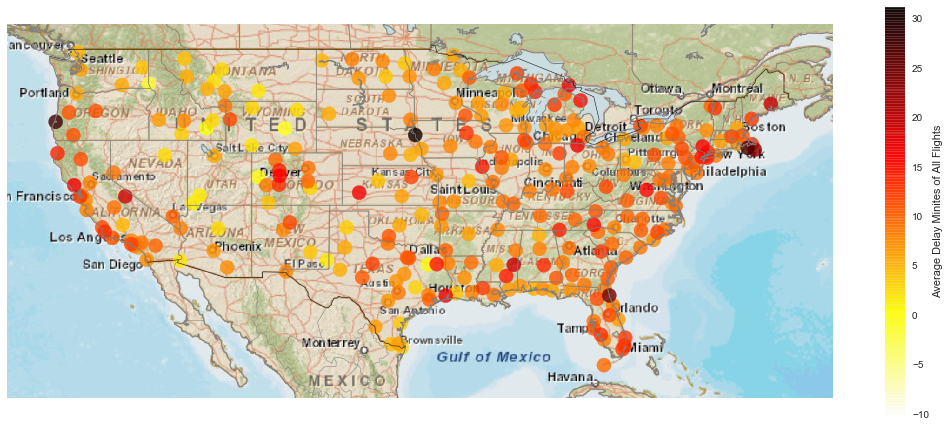

In [257]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['all_avr_delay'].values
m = Basemap(llcrnrlon=-128,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-96, resolution='l', epsg=4687)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=200)

plt.colorbar(label=r'Average Delay Minites of All Flights')
plt.clim(avr_delay['all_avr_delay'].min(), avr_delay['all_avr_delay'].max())

fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

plt.show()

In [182]:
from math import log10

# Average Delay Minutes for Delayed Flights

In [350]:
avr_delay['delay_count'].values / avr_delay['total_count'].values * 40

array([ 3.3970276 ,  3.80685794,  2.3255814 ,  2.81208936,  3.32033426,
        3.59281437,  4.27672956,  4.12698413,  3.18141197,  4.03722262,
        3.84781048,  8.84422111,  4.52198186,  4.35733443,  1.77595628,
        6.13496933,  3.82359525,  3.48148148,  2.52650177,  2.44436337,
        2.85311905,  3.41428054,  2.63574064,  3.04284465,  3.91554702,
        3.27784679,  2.75436793,  3.48111658,  3.56054531,  3.02158273,
        2.87718251,  2.04667864,  3.63200804,  2.58660508,  3.40371081,
        3.11108316,  3.28387735,  2.65417642,  3.39459013,  2.75659824,
        3.60065466,  3.50969438,  3.90079298,  4.54054054,  5.49019608,
        4.07499585,  4.52252252,  4.63872832,  3.93296089,  4.96717724,
        4.87623762,  4.02308326,  3.74844849,  3.91608392,  4.71427248,
        3.70828183,  6.24417521,  5.82807188,  3.12703583,  4.34213305,
        3.80816034,  4.25215166,  4.74136369,  4.44444444,  4.87515718,
        3.8496359 ,  4.35819381,  4.8106095 ,  4.20697792,  2.91

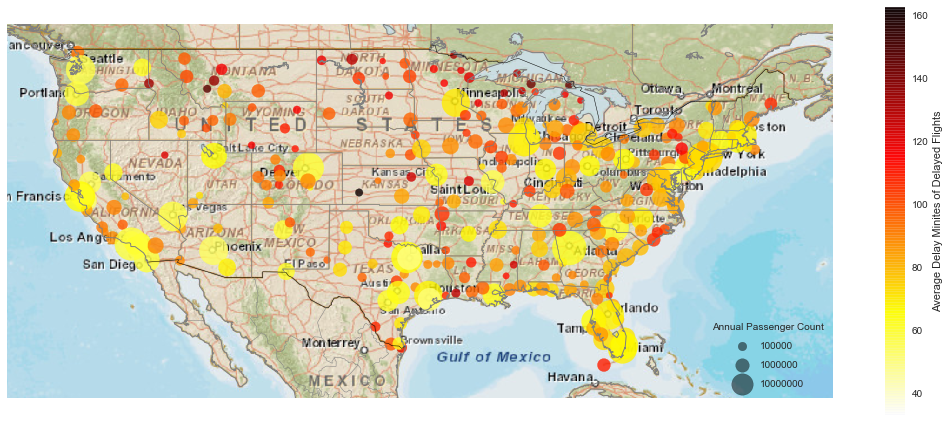

In [363]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
# size = avr_delay['avr_delay'].apply(lambda x: log10(x)).values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
# size = avr_delay['delay_count'].values / avr_delay['total_count'].values
colors = avr_delay['avr_delay'].values
m = Basemap(llcrnrlon=-128,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-96, resolution='l', epsg=4687)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s= 2.5 ** size)

plt.colorbar(label=r'Average Delay Minites of Delayed Flights')
# plt.clim(log10(avr_delay['avr_delay'].min()), log10(avr_delay['avr_delay'].max()))
plt.clim(avr_delay['avr_delay'].min(), avr_delay['avr_delay'].max())

# make legend with dummy points
for a in [50000, 500000, 5000000]:
    plt.scatter([], [], c='k', alpha=0.5, s=2.5 ** log10(a),
                label=str(2*a))
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower right', title='Annual Passenger Count');


fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

plt.show()

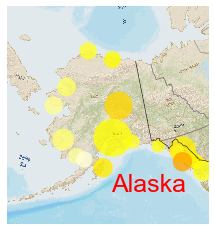

In [364]:
# Alaska
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
# a = plt.axes([.7, .1, .2, .2])
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
colors = avr_delay['avr_delay'].values
# plt.figure(edgecolor='r', linewidth=2)
m = Basemap(llcrnrlon=-170,llcrnrlat=50,urcrnrlon=-110,urcrnrlat=72,
        projection='lcc',lat_1=59,lat_2=66,lon_0=-142, resolution='l', epsg=2964)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s= 2.5 ** size * 4)
ax_2 = plt.gca()
ax_2.text(.7,.15,'Alaska',
        horizontalalignment='center',
        transform=ax_2.transAxes, color='red', fontsize=25)
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig_2 = plt.gcf()


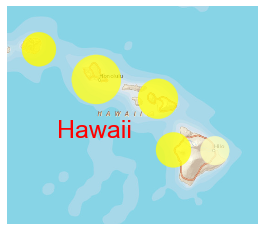

In [365]:
# Hawaii
# df_hawaii = delay_percentage[delay_percentage['STATE'] == 'Hawaii']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
colors = avr_delay['avr_delay'].values
m = Basemap(llcrnrlon=-160,llcrnrlat=18,urcrnrlon=-154,urcrnrlat=23,
        projection='lcc',lat_1=19.5,lat_2=22,lon_0=-156, resolution='l', epsg=2782)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=500)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s= 2.5 ** size * 4)
ax_3 = plt.gca()
ax_3.text(.35,.4,'Hawaii',
        horizontalalignment='center',
        transform=ax_3.transAxes, color='red', fontsize=25)
fig_3 = plt.gcf()

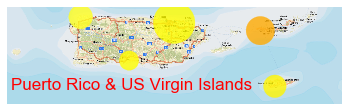

In [366]:
# Puerto Rico & US Virgin Islands
# df_pr = delay_percentage[(delay_percentage['STATE'] == 'Puerto Rico') | (delay_percentage['STATE'] == 'United States Virgin Islands')]
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['avr_delay'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
m = Basemap(llcrnrlon=-68,llcrnrlat=17.5,urcrnrlon=-64,urcrnrlat=18.6,
        projection='lcc',lat_1=18,lat_2=18.5,lon_0=-66, resolution='l', epsg=2866)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=2.5 ** size * 4)
ax_4 = plt.gca()
ax_4.text(.37,.15,'Puerto Rico & US Virgin Islands',
        horizontalalignment='center',
        transform=ax_4.transAxes, color='red', fontsize=17)
fig_4 = plt.gcf()

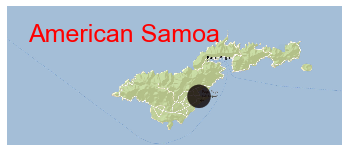

In [369]:
# American Samoa
# df_as = delay_percentage[delay_percentage['STATE'] == 'American Samoa']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['avr_delay'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
m = Basemap(llcrnrlon=-171,llcrnrlat=-14.4,urcrnrlon=-170.5,urcrnrlat=-14.2,
        projection='lcc',lat_1=-14.4,lat_2=-14.2,lon_0=-170.75, resolution='l', epsg=3102)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=2.5 ** size * 100 / 16)
ax_5 = plt.gca()
ax_5.text(.35,.75,'American Samoa',
        horizontalalignment='center',
        transform=ax_5.transAxes, color='red', fontsize=25)
fig_5 = plt.gcf()

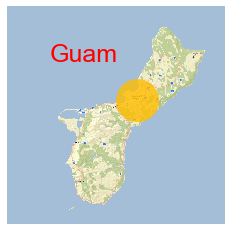

In [370]:
# Guam
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['avr_delay'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
m = Basemap(llcrnrlon=144.5,llcrnrlat=13.2,urcrnrlon=145,urcrnrlat=13.7,
        projection='lcc',lat_1=13.3,lat_2=13.6,lon_0=144.75, resolution='l', epsg=4675)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=2.5 ** size * 100 / 16)
ax_6 = plt.gca()
ax_6.text(.35,.75,'Guam',
        horizontalalignment='center',
        transform=ax_6.transAxes, color='red', fontsize=25)
fig_6 = plt.gcf()

In [43]:
pd.Series(statenames).unique()

array(['West Virginia', 'Illinois', 'Maryland', 'Idaho', 'Vermont',
       'Connecticut', 'New Mexico', 'New Jersey', 'Nebraska',
       'Pennsylvania', 'Georgia', 'Colorado', 'South Carolina',
       'Oklahoma', 'North Dakota', 'Kentucky', 'Guam', 'Nevada', 'Alaska',
       'Arkansas', 'Kansas', 'South Dakota', 'Virginia', 'Iowa',
       'Arizona', 'Rhode Island', 'New Hampshire', 'North Carolina',
       'Delaware', 'California', 'Wisconsin', 'Oregon', 'Washington',
       'Louisiana', 'Utah', 'Ohio', 'Texas', 'Tennessee',
       'Commonwealth of the Northern Mariana Islands', 'New York',
       'Maine', 'American Samoa', 'Michigan', 'Montana', 'Indiana',
       'Puerto Rico', 'Massachusetts', 'District of Columbia', 'Wyoming',
       'Mississippi', 'Florida', 'Hawaii', 'Minnesota', 'Alabama',
       'Missouri', 'United States Virgin Islands'], dtype=object)

In [79]:
delay_percentage.STATE.unique()

array(['Pennsylvania', 'Texas', 'New Mexico', 'South Dakota', 'Georgia',
       'Massachusetts', 'California', 'New Jersey', 'Alaska', 'Louisiana',
       'New York', 'Iowa', 'Michigan', 'Colorado', 'Wisconsin',
       'North Carolina', 'Connecticut', 'Maine', 'Alabama', 'Montana',
       'North Dakota', 'Minnesota', 'Washington', 'Illinois', 'Tennessee',
       'Idaho', 'Puerto Rico', 'Vermont', 'Maryland', 'South Carolina',
       'Ohio', 'Utah', 'Missouri', 'Virginia', 'West Virginia', 'Wyoming',
       'Kentucky', 'Florida', 'Nevada', 'Oregon', 'Indiana', 'Arizona',
       'Arkansas', 'Kansas', 'Mississippi', 'Nebraska',
       'Commonwealth of the Northern Mariana Islands', 'Hawaii',
       'Oklahoma', 'New Hampshire', 'American Samoa', 'Rhode Island',
       'United States Virgin Islands'], dtype=object)

1

In [54]:
list(map(lambda x: (x[0] + 2, x[1]-2), a))
# lambda kv: (-kv[1], kv[0])

[(3, 0), (6, 6)]

In [41]:
enumerate(m.states)

In [40]:
statenames

AttributeError: 'list' object has no attribute 'unique'

In [6]:
stations_df.head()

WBAN  LATITUDE  LONGITUDE IATA
0   398  18.00000  -66.55000  PSE
1  3017  39.83280 -104.65750  DEN
2  3102  34.05611 -117.60028  ONT
3  3103  35.14410 -111.66630  FLG
4  3145  32.65000 -114.61667  YUM

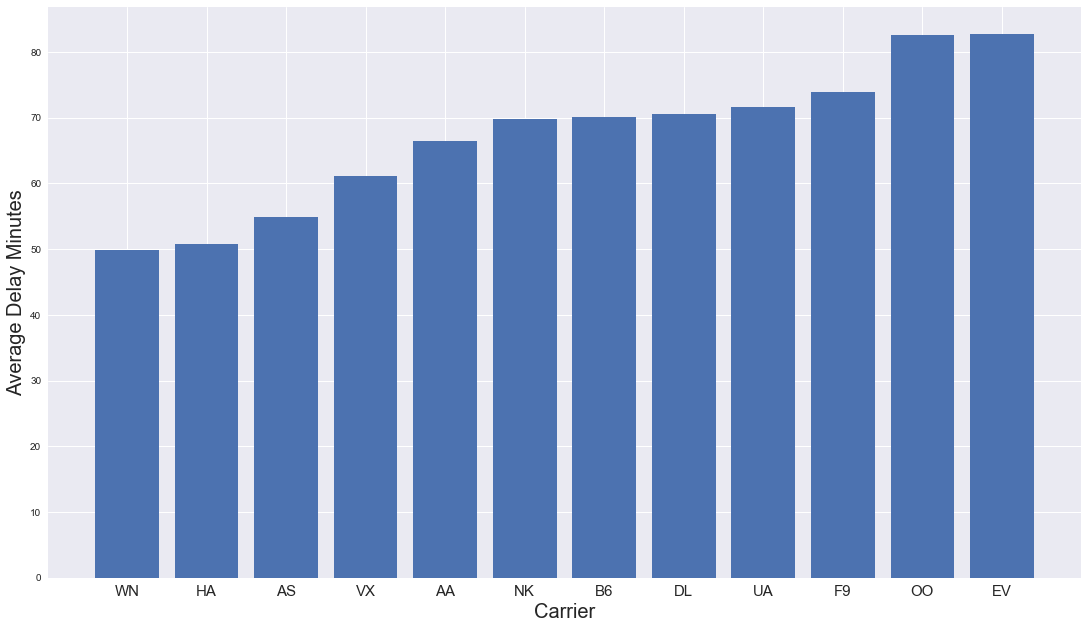

In [108]:
delayed_flight_carrier = delayed_flight.groupby('OP_CARRIER').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_carrier.index, delayed_flight_carrier.values)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# tail num add seats

In [4]:
tail_num_df = pd.read_csv('../tail_num/tail_num_with_number_of_seats.csv')

In [60]:
df[df['model_2'] == '737-800'].groupby('carrier').number_of_seats.describe()

count        mean      std    min    25%    50%    75%    max
carrier                                                               
AA       304.0  160.789474  2.97987  160.0  160.0  160.0  160.0  172.0
AS        61.0  159.000000  0.00000  159.0  159.0  159.0  159.0  159.0
DL        77.0  160.000000  0.00000  160.0  160.0  160.0  160.0  160.0
UA       136.0  166.000000  0.00000  166.0  166.0  166.0  166.0  166.0
WN       179.0  175.000000  0.00000  175.0  175.0  175.0  175.0  175.0

In [5]:
df = df.merge(tail_num_df, left_on='TAIL_NUM', right_on='tail_num', how='left')

In [8]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0  2016        1      1             1            5  2016-01-01   
1  2016        1      1             1            5  2016-01-01   
2  2016        1      1             1            5  2016-01-01   
3  2016        1      1             1            5  2016-01-01   
4  2016        1      1             1            5  2016-01-01   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  \
0                B6                  20409         B6   N636JB   
1                B6                  20409         B6   N547JB   
2                WN                  19393         WN   N927WN   
3                UA                  19977         UA   N62849   
4                EV                  20366         EV   N10575   

           ...           HOURLYPRSENTWEATHERTYPE_dest  \
0          ...                                    NaN   
1          ...                                    NaN   
2          ...                                    NaN   
3          ...                                    NaN   
4          ...                                    NaN   

   HOURLYDRYBULBTEMPF_dest  HOURLYRelativeHumidity_dest  HOURLYWindSpeed_dest  \
0                       73                           83                     0   
1                       34                           50                    11   
2                       34                           50                    11   
3                       34                           50                    11   
4                       34                           50                    11   

  HOURLYWindDirection_dest HOURLYWindGustSpeed_dest HOURLYPrecip_dest  \
0                      000                      NaN               NaN   
1                      240                      NaN              0.00   
2                      240                      NaN              0.00   
3                      240                      NaN              0.00   
4                      240                      NaN              0.00   

   HOURLYAltimeterSetting_dest origin_passenger_count  dest_passenger_count  
0                        30.03             21565448.0               89334.0  
1                        30.05             21565448.0            21571198.0  
2                        30.05              7194745.0            21571198.0  
3                        30.05             19603731.0            21571198.0  
4                        30.05             18409704.0            21571198.0  

[5 rows x 123 columns]

In [14]:
type(avr_seats)

pandas.core.series.Series

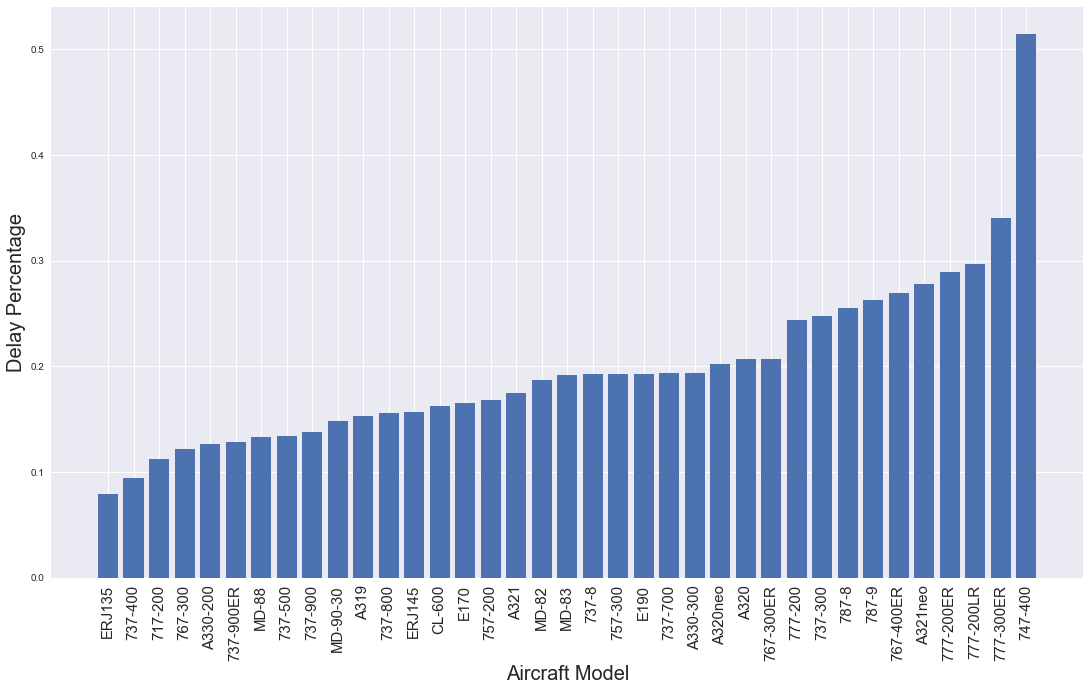

In [9]:
all_flights_model_count = np.array(df.groupby('model_2').DEP_DELAY.count().tolist())
delay_flights_model_count = np.array(df_flight_time.groupby('model_2').delay.count().tolist())
model_names = df.groupby('model_2').DEP_DELAY.count().index.tolist()
model_delay_percentage = pd.DataFrame(delay_flights_model_count / all_flights_model_count, index=model_names, columns=['delay_percentage'])
model_delay_percentage = model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(model_delay_percentage.index, model_delay_percentage.delay_percentage)
plt.xticks(model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [52]:
avr_seats = tail_num_df.groupby('model_2').number_of_seats.mean().sort_values()

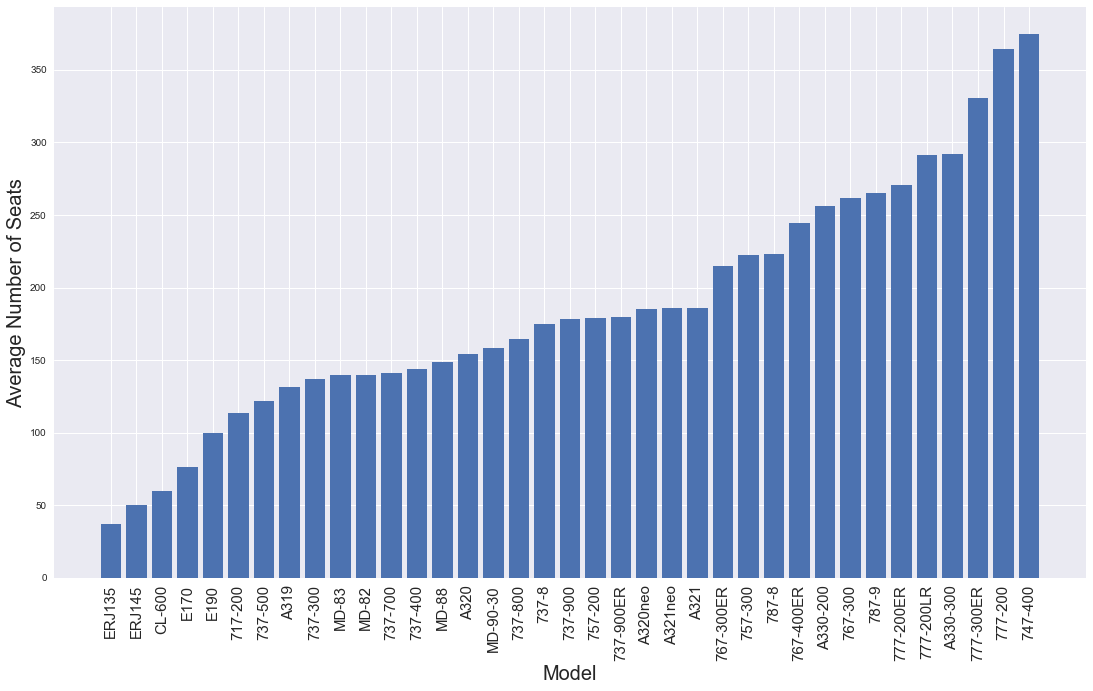

In [10]:
avr_seats = tail_num_df.groupby('model_2').number_of_seats.mean().sort_values()
plt.bar(avr_seats.index, avr_seats.values)
plt.xticks(avr_seats.index, rotation=90, fontsize=15)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Average Number of Seats', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [18]:
df1 = model_delay_percentage.reset_index().rename(columns={'index': 'model_2'}).merge(avr_seats.reset_index(), on='model_2')

In [20]:
df1 = df1.sort_values(by='number_of_seats')

In [53]:
avr_seats.index

Index(['ERJ135', 'ERJ145', 'CL-600', 'E170', 'E190', '717-200', '737-500',
       'A319', '737-300', 'MD-83', 'MD-82', '737-700', '737-400', 'MD-88',
       'A320', 'MD-90-30', '737-800', '737-8', '737-900', '757-200',
       '737-900ER', 'A320neo', 'A321neo', 'A321', '767-300ER', '757-300',
       '787-8', '767-400ER', 'A330-200', '767-300', '787-9', '777-200ER',
       '777-200LR', 'A330-300', '777-300ER', '777-200', '747-400'],
      dtype='object', name='model_2')

In [71]:
df1 = df1.reset_index(drop=True)

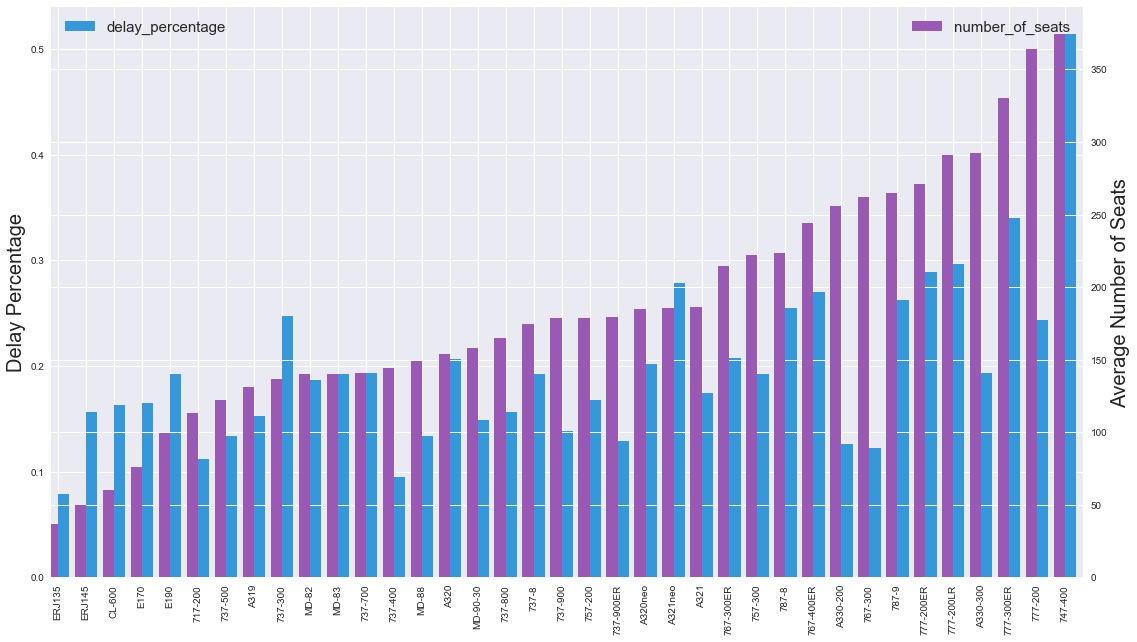

In [82]:
# df1.plot(x='model_2', kind='bar')

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

# width = 0.4
df1.number_of_seats.plot(kind='bar', color='#9b59b6', ax=ax2, width=width, position=1)
df1.delay_percentage.plot(kind='bar', color='#3498db', ax=ax, width=width, position=0)

ax.set_xticklabels(df1['model_2'])
# plt.set_xlabel('Model', fontsize=20)
ax2.set_ylabel('Average Number of Seats', fontsize=20)
ax.set_ylabel('Delay Percentage', fontsize=20)
ax.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
# ax.set_ylabel('delay_percentage')
# ax2.set_ylabel('number_of_seats')



fig.set_size_inches(18.5, 10.5)

In [10]:
df[df['carrier'] == 'AA'].groupby('model_2').count()

tail_num  mfr_name  model  year  cert_year  eng_mfr_name  \
model_2                                                               
737-8             2         2      2     2          2             2   
737-800         304       304    304   304        304           304   
757-200          81        81     81    81         77            81   
767-300ER        46        46     46    46         46            46   
777-200ER        47        47     47    47         47            47   
777-300ER        20        20     20    20         20            20   
787-8            20        20     20    20         20            20   
787-9            14        14     14    14         14            14   
A319            218       218    218   218        218           218   
A320            105       105    105   105        104           105   
A321            340       340    340   340        340           340   
A330-200         30        30     30    30         30            30   
A330-300         18        18     18    18         18            18   
E190             40        40     40    40         40            40   
MD-82            44        44     44    44         44            44   
MD-83            51        51     51    51         51            51   

           eng_model  carrier  number_of_seats  
model_2                                         
737-8              2        2                2  
737-800          304      304              304  
757-200           81       81               81  
767-300ER         46       46               46  
777-200ER         47       47               47  
777-300ER         20       20               20  
787-8             20       20               20  
787-9             14       14               14  
A319             218      218              218  
A320             105      105              105  
A321             340      340              340  
A330-200          30       30               30  
A330-300          18       18               18  
E190              40       40               40  
MD-82             44       44               44  
MD-83             51       51               51

In [11]:
df[(df['carrier'] == 'AA') & (df['model_2'] == '777-200ER')].groupby('model').count()

tail_num  mfr_name  model_2  year  cert_year  eng_mfr_name  \
model                                                                   
777-223ER        47        47       47    47         47            47   

           eng_model  carrier  number_of_seats  
model                                           
777-223ER         47       47               47

In [57]:
df[(df['carrier'] == 'AA') & (df['model_2'] == 'A321')].number_of_seats.unique()

array([187., 181., 102.])

In [21]:
df[(df['carrier'] == 'AA') & (df['model_2'] == 'A321')].sort_values(by='tail_num')

tail_num mfr_name     model model_2    year  cert_year eng_mfr_name  \
4837   N150AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
1022   N150UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4941   N151AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
870    N151UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4907   N152AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
938    N152UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4924   N153AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
1000   N153UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4932   N154AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
949    N154UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4906   N155AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
951    N155UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4936   N156AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
1068   N156UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4866   N157AA   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
837    N157UW   AIRBUS  A321-211    A321  2013.0     2015.0     CFM INTL   
4919   N161AA   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
868    N161UW   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
4910   N162AA   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
927    N162UW   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
4948   N163AA   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
912    N163US   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
4868   N165AA   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
859    N165US   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
4943   N167AA   AIRBUS  A321-211    A321  2001.0     2001.0     CFM INTL   
984    N167US   AIRBUS  A321-211    A321  2001.0     2001.0     CFM INTL   
4867   N169AA   AIRBUS  A321-211    A321  2001.0     2001.0     CFM INTL   
1034   N169UW   AIRBUS  A321-211    A321  2001.0     2001.0     CFM INTL   
4949   N170AA   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
978    N170US   AIRBUS  A321-211    A321  2001.0     2015.0     CFM INTL   
...       ...      ...       ...     ...     ...        ...          ...   
1057   N974UY   AIRBUS  A321-231    A321  2011.0     2015.0          IAE   
4838   N975AA   AIRBUS  A321-231    A321  2011.0     2015.0          IAE   
944    N975UY   AIRBUS  A321-231    A321  2011.0     2015.0          IAE   
4880   N976AA   AIRBUS  A321-231    A321  2012.0     2012.0          IAE   
1289   N976UY   AIRBUS  A321-231    A321  2012.0     2012.0          IAE   
4862   N977AA   AIRBUS  A321-231    A321  2012.0     2015.0          IAE   
907    N977UY   AIRBUS  A321-231    A321  2012.0     2015.0          IAE   
4843   N978AA   AIRBUS  A321-231    A321  2012.0     2015.0          IAE   
967    N978UY   AIRBUS  A321-231    A321  2012.0     2015.0          IAE   
4874   N979AA   AIRBUS  A321-231    A321  2013.0     2015.0          IAE   
958    N979UY   AIRBUS  A321-231    A321  2013.0     2015.0          IAE   
4856   N980AA   AIRBUS  A321-231    A321  2013.0     2015.0          IAE   
1002   N980UY   AIRBUS  A321-231    A321  2013.0     2015.0          IAE   
4923   N981AA   AIRBUS  A321-231    A321  2013.0     2015.0          IAE   
864    N981UY   AIRBUS  A321-231    A321  2013.0     2015.0          IAE   
4852   N982AA   AIRBUS  A321-231    A321  2012.0     2015.0          IAE   
830    N982VJ   AIRBUS  A321-231    A321  2012.0     2015.0          IAE   
4788   N986AA   AIRBUS  A321-231    A321  2016.0     2016.0          IAE   
4771   N987AA   AIRBUS  A321-231    A321  2016.0     2016.0          IAE   
4792   N988AA   AIRBUS  A321-231    A321  2016.0     2016.0          IAE   
4768   N989AA   AIRBUS  A321-231    A321  2016.0     

In [20]:
def function(lst):
    if lst[0] == 'AA' and lst[1] == 'A321':
        lst[2] = 187
    else:
        pass
    return lst[2]
        
df['number_of_seats'] = df[['carrier', 'model_2', 'number_of_seats']].apply(function, axis=1)

In [39]:
df[(df['tail_num'].str.match(r'^N5[A-Z]{2}AA$')) & (df['carrier'] == 'AA') & (df['model_2'] == '757-200')].sort_values(by='tail_num')

tail_num mfr_name    model  model_2    year  cert_year eng_mfr_name  \
4734   N5CKAA   BOEING  757-223  757-200  1992.0     2018.0   ROLLS-ROYC   
4642   N5DEAA   BOEING  757-223  757-200  1993.0     2018.0   ROLLS-ROYC   
4644   N5DFAA   BOEING  757-223  757-200  1993.0     2017.0   ROLLS-ROYC   
4422   N5DGAA   BOEING  757-223  757-200  1993.0     2017.0   ROLLS-ROYC   
4704   N5DHAA   BOEING  757-223  757-200  1993.0     2017.0   ROLLS-ROYC   
4554   N5DJAA   BOEING  757-223  757-200  1993.0     1993.0   ROLLS-ROYC   
4402   N5DKAA   BOEING  757-223  757-200  1993.0     1993.0   ROLLS-ROYC   
4426   N5DVAA   BOEING  757-223  757-200  1995.0     2018.0   ROLLS-ROYC   
4425   N5EAAA   BOEING  757-223  757-200  1996.0     2018.0   ROLLS-ROYC   
4553   N5ECAA   BOEING  757-223  757-200  1996.0     2017.0   ROLLS-ROYC   
4643   N5EHAA   BOEING  757-223  757-200  1998.0     2018.0   ROLLS-ROYC   
4645   N5EJAA   BOEING  757-223  757-200  1998.0     2017.0   ROLLS-ROYC   
4468   N5EKAA   BOEING  757-223  757-200  1998.0     2017.0   ROLLS-ROYC   
4421   N5ELAA   BOEING  757-223  757-200  1999.0     2018.0   ROLLS-ROYC   
4728   N5ENAA   BOEING  757-223  757-200  1999.0     1999.0   ROLLS-ROYC   
4423   N5EPAA   BOEING  757-223  757-200  1999.0     1999.0   ROLLS-ROYC   
4397   N5ERAA   BOEING  757-223  757-200  1999.0     1999.0   ROLLS-ROYC   
4467   N5ESAA   BOEING  757-223  757-200  1999.0     1999.0   ROLLS-ROYC   
4398   N5ETAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4424   N5EUAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4563   N5EVAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4401   N5EWAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4415   N5EXAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4417   N5EYAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4579   N5FAAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4578   N5FBAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4419   N5FCAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4565   N5FDAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4404   N5FEAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4416   N5FFAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4551   N5FGAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4464   N5FHAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4420   N5FJAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4577   N5FKAA   BOEING  757-223  757-200  2001.0     2001.0   ROLLS-ROYC   
4576   N5FLAA   BOEING  757-223  757-200  2002.0     2002.0   ROLLS-ROYC   
4400   N5FMAA   BOEING  757-223  757-200  2002.0     2002.0   ROLLS-ROYC   
4552   N5FNAA   BOEING  757-223  757-200  2002.0     2017.0   ROLLS-ROYC   
4550   N5FPAA   BOEING  757-223  757-200  2002.0     2017.0   ROLLS-ROYC   
4566   N5FRAA   BOEING  757-223  757-200  2002.0     2017.0   ROLLS-ROYC   
4418   N5FSAA   BOEING  757-223  757-200  2002.0     2002.0   ROLLS-ROYC   
4456   N5FTAA   BOEING  757-223  757-200  2002.0     2002.0   ROLLS-ROYC   

         eng_model carrier  number_of_seats  
4734  RB211-535E4B      AA            176.0  
4642  RB211-535E4B      AA            176.0  
4644  RB211-535E4B      AA            176.0  
4422  RB211-535E4B      AA            176.0  
4704  RB211-535E4B      AA            176.0  
4554  RB211-535E4B      AA            176.0  
4402  RB211-535E4B      AA            176.0  
4426  RB211-535E4B      AA            176.0  
4425  RB211-535E4B      AA            176.0  
4553  RB211-535E4B      AA            176.0  
4643  RB211-535E4B      AA            176.0  
4645  RB211-535E4B      AA            176.0  
4468  RB211-535E4B      AA            176.0  
4421  RB211-535E4B      AA            176.0  
4728  RB211-535E4B      AA            176.0  
4423  RB211-535E4B      AA            176.0  
4397  RB211-535E4B      AA    

In [14]:
# AA 772ER
idx = df[df['tail_num'].str.match(r'^N7(A[DS]|B[DGKNRSUVW]|CC)AA$')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 260

In [38]:
# AA 757-200
idx = df[(df['tail_num'].str.match(r'^N5[A-Z]{2}AA$')) & (df['carrier'] == 'AA') & (df['model_2'] == '757-200')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 176

In [34]:
# AA 737-800 Classic
idx = df[(df['tail_num'].str.match(r'^N3(D[MNPRSTUVXY]|E[ABEFGJLMV]|FC)AA$')) & (df['carrier'] == 'AA') & (df['model_2'] == '737-800')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 172

In [28]:
# AA A321 Enhanced
idx = df[(df['tail_num'].str.match(r'^N(78[3-9]|79\d|8[5-9]\d|90[1-9]|910|92[89]|93[0-4]|98[6-9]|99[0-8])AA$')) & (df['carrier'] == 'AA') & (df['model_2'] == 'A321')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 181

In [56]:
# AA A321T
idx = df[df['tail_num'].str.match(r'^N7(8[3-9]|9[0-9])AA$')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 102

In [72]:
# B6 A321 all Y
idx = df[df['tail_num'].str.match(r'^N9(0[357]|13|4[89]|5[0-9]|6[56]|7[0-5])J[A-Z]$')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 200

In [106]:
# DL 752
idx = df[(df['tail_num'].str.match(r'^N6([0-7][0-9]|8[0-4])D[A-Z]$')) & (df['carrier'] == 'DL')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 180

In [126]:
# DL 763ER
idx = df[(df['tail_num'].str.match(r'^N1(8[01789]|9[0-9])DN$')) & (df['carrier'] == 'DL')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 226

In [205]:
# NK 320
idx = df[df['tail_num'].str.match(r'^N6(4[1-9]|5[0-6])NK$')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 182

In [252]:
# UA 763ER
idx = df[(df['tail_num'].str.match(r'^N6(41|54|60)UA$')) & (df['carrier'] == 'UA')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 183

In [262]:
# UA 772ER
idx = df[(df['tail_num'].str.match(r'^N78(6|8)UA$')) & (df['carrier'] == 'UA') & (df['model_2'] == '777-200ER')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 292
idx = df[(df['tail_num'].str.match(r'^N\d{5}$')) & (df['carrier'] == 'UA') & (df['model_2'] == '777-200ER')].index.tolist()
for i in idx:
    df.loc[i, 'number_of_seats'] = 267